## Setup

In [1]:
import tensorflow as tf
import csv
# from tensorflow import keras
# from tensorflow.keras import Sequential
# from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Dropout, GlobalAveragePooling1D, Dense
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

2022-11-15 14:44:43.206156: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
nucleo_dic = {
    'A': 0,
    'R': 1,
    'N': 2,
    'D': 3,
    'C': 4,
    'Q': 5,
    'E': 6,
    'G': 7,
    'H': 8,
    'I': 9,
    'L': 10,
    'K': 11,
    'M': 12,
    'F': 13,
    'P': 14,
    'S': 15,
    'T': 16,
    'W': 17,
    'Y': 18,
    'V': 19,
    'X': 20
}

BACKUP_FILE = '/home/jovyan/data/computed_scores_backup_SPOUT.pkl'

MODEL = 'knots_simple_CNN/cnn_10epochs.h5'
DATA_CSV = '/home/jovyan/data/proteins/SPOUT_knotted_small.csv'

# maximum length of input sequence (limited by the CNN):
SEQ_DIM = 500
PATCH_CHAR = 'X'
DEFAULT_PATCH_SIZE = 50

In [3]:
model = tf.keras.models.load_model(MODEL)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 493, 32)           5408      
                                                                 
 batch_normalization (BatchN  (None, 493, 32)          128       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 246, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 239, 16)           4112      
                                                                 
 batch_normalization_1 (Batc  (None, 239, 16)          64        
 hNormalization)                                                 
                                                        

2022-11-15 14:44:46.317185: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-15 14:44:46.713006: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 43652 MB memory:  -> device: 0, name: NVIDIA A40, pci bus id: 0000:a3:00.0, compute capability: 8.6


## Load data:

In [4]:
with open(DATA_CSV, newline='') as f:
    reader = csv.reader(f, delimiter=';')
    data = list(reader)

data[0]

['\ufeffseq', 'knotted?']

In [5]:
test_seq = data[1][0]
test_seq

'MLLVKTLREMEYVAASHIKDAIGDVEIEIRPSGFLGLLIVHCDESLKEKLEEIPEIETIIPVLVECEAKLDEILSKAEVVAEKVKGARTFAIRTKRRGTHDFTSLDVNLDLGDRIRELTGCEVDLNFPDKAVYVEIIGKRAFIGVIDGSEERKKYTPEKVDSRKLFGKISFVQMPYLEDTKAALEIGERIGRAAQAFEIKELIIAPHDYVNAFELEYFIKGVRRGQIARYKIQERAYAREVRKVPVFVRDLYQTARDKRRKRNVLIITDPTGRQISDVKEELVRRIRFADEVVIFAGSRVGIPKGLFRLADFVIDLAPYITFATEQTIPVTLSALLTVYEEDEEARGVIKSL'

# Looking for the knot core:

In [6]:
def fix_seq_size(seq):
    if len(seq) < SEQ_DIM:
        seq += 'X' * (SEQ_DIM-len(seq))
    elif len(seq) > SEQ_DIM:
        seq = seq[SEQ_DIM:]
    return seq

def get_seq_prediction(seq):
    seq_onehot = tf.one_hot([nucleo_dic[c] for c in seq], depth=21)
    prediction = model.predict(np.expand_dims(seq_onehot, axis=0), verbose=0)
    return prediction[0][0]

In [7]:
test_seq = fix_seq_size(test_seq)
get_seq_prediction(test_seq)

2022-11-15 14:44:47.972805: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-11-15 14:44:48.895185: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-15 14:44:48.895612: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-15 14:44:48.895631: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2022-11-15 14:44:48.896140: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2022-11-15 14:44:48.896198: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


0.99978

In [8]:
def iterate_patch_over_seq(seq, patch_size, overlap_step, patch_char=PATCH_CHAR):
    scores = []
    
    # get prediction for the original sequence:
    prediction = get_seq_prediction(seq)
    scores.append({'position': -1,
                   'interval': (-1, -1),
                   'patched_seq': seq, 
                   'prediction': prediction,
                   'patched_subseq': ''}) 
    
    # get prediction for all patched versions of the original sequence:
    patch = patch_char * patch_size
    last_patch_start_i = SEQ_DIM-patch_size
    for i in range(0, last_patch_start_i, overlap_step):
        patched_subseq = seq[i:i+patch_size]
        patched_seq = seq[:i] + patch + seq[i+patch_size:]
        prediction = get_seq_prediction(patched_seq)
        scores.append({'position': i,
                       'interval': (i, i+patch_size),
                       'patched_seq': patched_seq, 
                       'prediction': prediction,
                       'patched_subseq': patched_subseq}) 
    return scores

Sequential patching of the input sequence:

- the patch size, patch symbol and step between patches can be specified

In [9]:
# plot separate graph for each PATCH df:

# def calculate_one_seq_results(seq, patches=[DEFAULT_PATCH_SIZE], overlap_step=1):
#     print('==== Sequence patch results: ======================================================================')
#     print(seq)
#     all_scores = {}
    
#     for patch_size in patches:
#         print(f'\nCalculating PATCH={patch_size} results...')
#         scores = iterate_patch_over_seq(seq, patch_size, overlap_step)
#         all_scores[patch_size] = scores
#         df_scores = pd.DataFrame(scores)
    
#         plt.plot(df_scores['position'], df_scores['prediction'])
#         plt.show()

#         # get index of the sequence which resulted in the lowest prediction score (+ add the pattern that was patched):
#         min_i = df_scores['prediction'].idxmin()
#         print(f'Min prediction for seq version (i={min_i}): {df_scores.iloc[min_i]["patched_seq"]}')
#         print(f'Patched subseq: {df_scores.iloc[min_i]["patched_subseq"]}')
        
#     print('===================================================================================================\n')

#     return all_scores

In [10]:
# # plot all PATCH df prediction info in one graph with line legend:

# def calculate_one_seq_results(seq, patches=[DEFAULT_PATCH_SIZE], overlap_step=1):
#     print('==== Sequence patch results: ======================================================================')
#     print(seq)
#     all_scores = {}
    
#     for patch_size in patches:
#         print(f'\nCalculating PATCH={patch_size} results...')
#         scores = iterate_patch_over_seq(seq, patch_size, overlap_step)
#         all_scores[patch_size] = scores
#         df_scores = pd.DataFrame(scores)

#         # get index of the sequence which resulted in the lowest prediction score (+ add the pattern that was patched):
#         min_i = df_scores['prediction'].idxmin()
#         print(f'Min prediction for seq version (i={min_i}): {df_scores.iloc[min_i]["patched_seq"]}')
#         print(f'Patched subseq: {df_scores.iloc[min_i]["patched_subseq"]}')
        
#         plt.plot(df_scores['position'], df_scores['prediction'], label=patch_size)

#     plt.legend(loc='right')
#     plt.show()
        
#     print('===================================================================================================\n')

#     return all_scores

In [11]:
# plot all PATCH df prediction info in separate graphs next to each other with line legend:

def calculate_one_seq_results(seq, patches=[DEFAULT_PATCH_SIZE], overlap_step=1):
    print('==== Sequence patch results: ======================================================================')
    print(seq)
    all_scores = {}
    patches_len = len(patches)
    
    plt_width = 5 * patches_len
    plt.rcParams['figure.figsize'] = (plt_width, 3)
    fig, ax = plt.subplots(ncols=patches_len)  # if ncols > 1, it returns array, otherwise returns already the object I need
    
    for i in range(patches_len):
        patch_size = patches[i]
        print(f'\nCalculating PATCH={patch_size} results...')
        scores = iterate_patch_over_seq(seq, patch_size, overlap_step)
        all_scores[patch_size] = scores
        df_scores = pd.DataFrame(scores)

        # get index of the sequence which resulted in the lowest prediction score (+ add the pattern that was patched):
        min_i = df_scores['prediction'].idxmin()
        print(f'Min prediction (= {df_scores.iloc[min_i]["prediction"]}) for seq version was at interval {df_scores.iloc[min_i]["interval"]} (df row index = {min_i}): {df_scores.iloc[min_i]["patched_seq"]}')
        print(f'Patched subseq: {df_scores.iloc[min_i]["patched_subseq"]}')
        
        current_ax = ax[i] if type(ax) is np.ndarray else ax
        df_scores.plot(x='position', y=['prediction'], ax=current_ax, ylim=(0.0,1.02)) # ylim to force y-axis scale to be the same as it is for the other graphs
        current_ax.legend([patch_size])
        
    print()
    plt.show()
        
    print('===================================================================================================\n')

    return all_scores

==== Sequence patch results: ======================================================================
MLLVKTLREMEYVAASHIKDAIGDVEIEIRPSGFLGLLIVHCDESLKEKLEEIPEIETIIPVLVECEAKLDEILSKAEVVAEKVKGARTFAIRTKRRGTHDFTSLDVNLDLGDRIRELTGCEVDLNFPDKAVYVEIIGKRAFIGVIDGSEERKKYTPEKVDSRKLFGKISFVQMPYLEDTKAALEIGERIGRAAQAFEIKELIIAPHDYVNAFELEYFIKGVRRGQIARYKIQERAYAREVRKVPVFVRDLYQTARDKRRKRNVLIITDPTGRQISDVKEELVRRIRFADEVVIFAGSRVGIPKGLFRLADFVIDLAPYITFATEQTIPVTLSALLTVYEEDEEARGVIKSLXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

Calculating PATCH=50 results...
Min prediction (= 0.17688153684139252) for seq version was at interval (148, 198) (df row index = 149): MLLVKTLREMEYVAASHIKDAIGDVEIEIRPSGFLGLLIVHCDESLKEKLEEIPEIETIIPVLVECEAKLDEILSKAEVVAEKVKGARTFAIRTKRRGTHDFTSLDVNLDLGDRIRELTGCEVDLNFPDKAVYVEIIGKRAFIGVIDGXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXIKELIIAPHDYVNAFELEYFIKGVRRGQIARYKIQERAYAREVRKVPVFVRDLYQTARDKRRKR

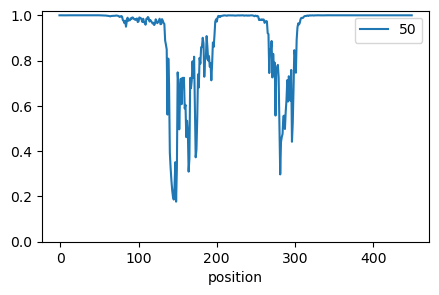

In [12]:
result = calculate_one_seq_results(test_seq)

It is possible to compute and directly display results for one sequence with different sized of the patch:

==== Sequence patch results: ======================================================================
MLLVKTLREMEYVAASHIKDAIGDVEIEIRPSGFLGLLIVHCDESLKEKLEEIPEIETIIPVLVECEAKLDEILSKAEVVAEKVKGARTFAIRTKRRGTHDFTSLDVNLDLGDRIRELTGCEVDLNFPDKAVYVEIIGKRAFIGVIDGSEERKKYTPEKVDSRKLFGKISFVQMPYLEDTKAALEIGERIGRAAQAFEIKELIIAPHDYVNAFELEYFIKGVRRGQIARYKIQERAYAREVRKVPVFVRDLYQTARDKRRKRNVLIITDPTGRQISDVKEELVRRIRFADEVVIFAGSRVGIPKGLFRLADFVIDLAPYITFATEQTIPVTLSALLTVYEEDEEARGVIKSLXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

Calculating PATCH=10 results...
Min prediction (= 0.5999353528022766) for seq version was at interval (190, 200) (df row index = 191): MLLVKTLREMEYVAASHIKDAIGDVEIEIRPSGFLGLLIVHCDESLKEKLEEIPEIETIIPVLVECEAKLDEILSKAEVVAEKVKGARTFAIRTKRRGTHDFTSLDVNLDLGDRIRELTGCEVDLNFPDKAVYVEIIGKRAFIGVIDGSEERKKYTPEKVDSRKLFGKISFVQMPYLEDTKAALEIGERIXXXXXXXXXXELIIAPHDYVNAFELEYFIKGVRRGQIARYKIQERAYAREVRKVPVFVRDLYQTARDKRRKRN

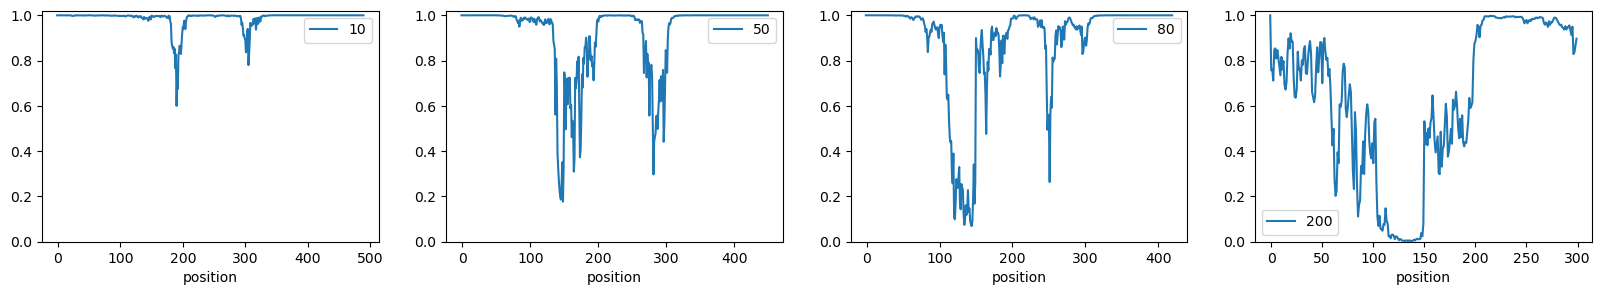

In [13]:
result = calculate_one_seq_results(test_seq, [10, 50, 80, 200])

==== Sequence patch results: ======================================================================
MLLVKTLREMEYVAASHIKDAIGDVEIEIRPSGFLGLLIVHCDESLKEKLEEIPEIETIIPVLVECEAKLDEILSKAEVVAEKVKGARTFAIRTKRRGTHDFTSLDVNLDLGDRIRELTGCEVDLNFPDKAVYVEIIGKRAFIGVIDGSEERKKYTPEKVDSRKLFGKISFVQMPYLEDTKAALEIGERIGRAAQAFEIKELIIAPHDYVNAFELEYFIKGVRRGQIARYKIQERAYAREVRKVPVFVRDLYQTARDKRRKRNVLIITDPTGRQISDVKEELVRRIRFADEVVIFAGSRVGIPKGLFRLADFVIDLAPYITFATEQTIPVTLSALLTVYEEDEEARGVIKSL

Calculating PATCH=10 results...
Min prediction (= 0.26605209708213806) for seq version was at interval (190, 200) (df row index = 191): MLLVKTLREMEYVAASHIKDAIGDVEIEIRPSGFLGLLIVHCDESLKEKLEEIPEIETIIPVLVECEAKLDEILSKAEVVAEKVKGARTFAIRTKRRGTHDFTSLDVNLDLGDRIRELTGCEVDLNFPDKAVYVEIIGKRAFIGVIDGSEERKKYTPEKVDSRKLFGKISFVQMPYLEDTKAALEIGERIXXXXXXXXXXELIIAPHDYVNAFELEYFIKGVRRGQIARYKIQERAYAREVRKVPVFVRDLYQTARDKRRKRNVLIITDPTGRQISDVKEELVRRIRFADEVVIFAGSRVGIPKGLFRLADFVIDLAPYITFATEQTIPVTLSALLTVYEEDEEARGVIKSL
Patched subseq: GRAAQAFEIK

Calculating PATCH=50 results.

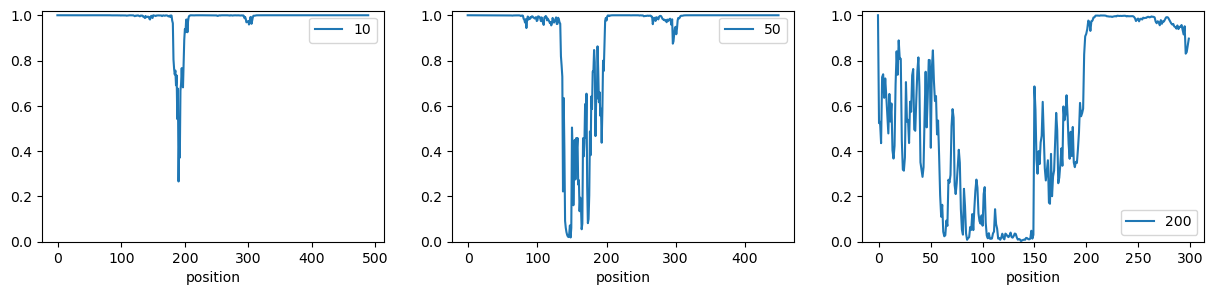


==== Sequence patch results: ======================================================================
MAKYIIKTQKGFENIVVNNLKEIIGDFKYTVSPDGYQGIVIVEHDEDIEDKILEIPEVERVLRVYFETETEFDKIVNLAEKIKDYIKEDETFAVETKKRGKHDFSSTDVNIVLGAKIKDLTNASVDLNNPDKVVHVEVFKNKTYVSITPGEKFKKYTKEKRNARELFRKVVIVQMPYLGEKIVCKRFGEAIGRAAQGFEVKELIIAPKEKVDAYELMEFIKGVKIGQHSRYEIQKRAYPFEIKLVPVTVQDLYQVVRDKRRDNRLLIITDPKGDELSKIKDKLAYDLRKKREIIVFCGSREGIPRGLFRFADYILDLAPHMTFATEHAIPAALIALWGVYSGEDLENSSEEEKTESNSNDE

Calculating PATCH=10 results...
Min prediction (= 0.9166102409362793) for seq version was at interval (188, 198) (df row index = 189): MAKYIIKTQKGFENIVVNNLKEIIGDFKYTVSPDGYQGIVIVEHDEDIEDKILEIPEVERVLRVYFETETEFDKIVNLAEKIKDYIKEDETFAVETKKRGKHDFSSTDVNIVLGAKIKDLTNASVDLNNPDKVVHVEVFKNKTYVSITPGEKFKKYTKEKRNARELFRKVVIVQMPYLGEKIVCKRFGXXXXXXXXXXEVKELIIAPKEKVDAYELMEFIKGVKIGQHSRYEIQKRAYPFEIKLVPVTVQDLYQVVRDKRRDNRLLIITDPKGDELSKIKDKLAYDLRKKREIIVFCGSREGIPRGLFRFADYILDLAPHMTFATEHAIPAALIALWGVYSGEDLENSSEEEKTESNSNDE
Patched subseq: EAIGRAAQGF

Calculating

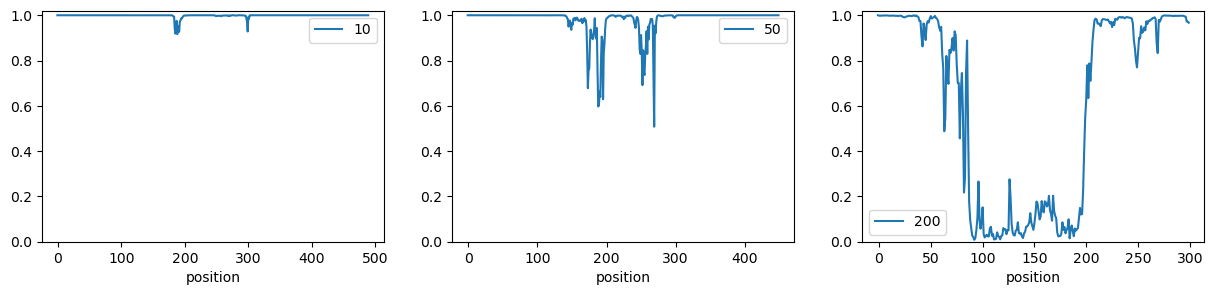


==== Sequence patch results: ======================================================================
MKFLVKTQRDMEAVAGNYITEAVPDAEVWIAPMGYTGLVLVEADENAYEKLLEIPEVERVIPVLVETEADLEKIAESAEKIAHLIGENETYAVKTKRRGKHDFSSIDVNRVLGARIKELSGADVNLSWPDKVVQVEIIGDRAYISVLPGEEYRKYTPNKIDARKLFRKLTVVQMPYWGDYKACRKFGEKIGRAAQAFEVKELIIAPKEKMDAFELMEFIKGVKIGQESRYKIQREAYPWKVEKVPVSVWDLYQVVRDKRRNKRLLIITDPKGPTLAEVKEELARDMHHAREVVVFIGSREGIPRGVFRFADYVVDLAPYMTFATEHGIPATLVSLWEVYEEFLRENGKEEKEGE

Calculating PATCH=10 results...
Min prediction (= 0.5862604379653931) for seq version was at interval (298, 308) (df row index = 299): MKFLVKTQRDMEAVAGNYITEAVPDAEVWIAPMGYTGLVLVEADENAYEKLLEIPEVERVIPVLVETEADLEKIAESAEKIAHLIGENETYAVKTKRRGKHDFSSIDVNRVLGARIKELSGADVNLSWPDKVVQVEIIGDRAYISVLPGEEYRKYTPNKIDARKLFRKLTVVQMPYWGDYKACRKFGEKIGRAAQAFEVKELIIAPKEKMDAFELMEFIKGVKIGQESRYKIQREAYPWKVEKVPVSVWDLYQVVRDKRRNKRLLIITDPKGPTLAEVKEELARDMHHAREVVVFIGSXXXXXXXXXXFADYVVDLAPYMTFATEHGIPATLVSLWEVYEEFLRENGKEEKEGE
Patched subseq: REGIPRGVFR

Calculating PATCH=50 resu

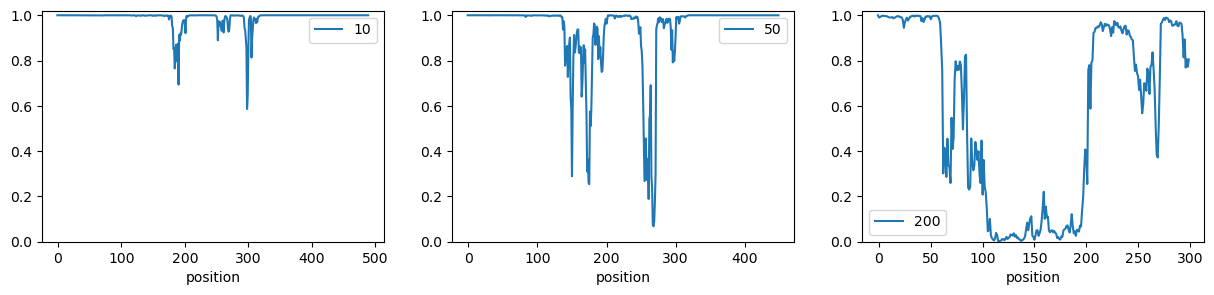


==== Sequence patch results: ======================================================================
MIFVKTQRGMEYIAAQNIKELLGDVKIEIRPAGYLGILVVHSDELEQVRQVPEVERAIPVLFEIESNLDEILEKAEEVVKAMGEFDTFAIRATRRGLKHRFSSMDISIQLGRRIQEISGRDVDLNTPDKAIYVEVVNERTFIGILDGAEERRKYTPEKADSLRFFEKVSFVQMPYLENLKGAREIGERIGRNAQSFEIKELIIAPYGYVDAEELFEFLRGVRRGKLSRLSIQRKSYAREVRETKILVHDLFQTLRDKKRRKYVVIATDPTGRQISDVRDELKRAFERANEIVIFAGSRTGLPKGVLRLADFVVDLSPYITFPTELAIPVSLTAFLDIYEEMKADRTKRER

Calculating PATCH=10 results...
Min prediction (= 0.25907161831855774) for seq version was at interval (189, 199) (df row index = 190): MIFVKTQRGMEYIAAQNIKELLGDVKIEIRPAGYLGILVVHSDELEQVRQVPEVERAIPVLFEIESNLDEILEKAEEVVKAMGEFDTFAIRATRRGLKHRFSSMDISIQLGRRIQEISGRDVDLNTPDKAIYVEVVNERTFIGILDGAEERRKYTPEKADSLRFFEKVSFVQMPYLENLKGAREIGERIXXXXXXXXXXELIIAPYGYVDAEELFEFLRGVRRGKLSRLSIQRKSYAREVRETKILVHDLFQTLRDKKRRKYVVIATDPTGRQISDVRDELKRAFERANEIVIFAGSRTGLPKGVLRLADFVVDLSPYITFPTELAIPVSLTAFLDIYEEMKADRTKRER
Patched subseq: GRNAQSFEIK

Calculating PATCH=50 results...


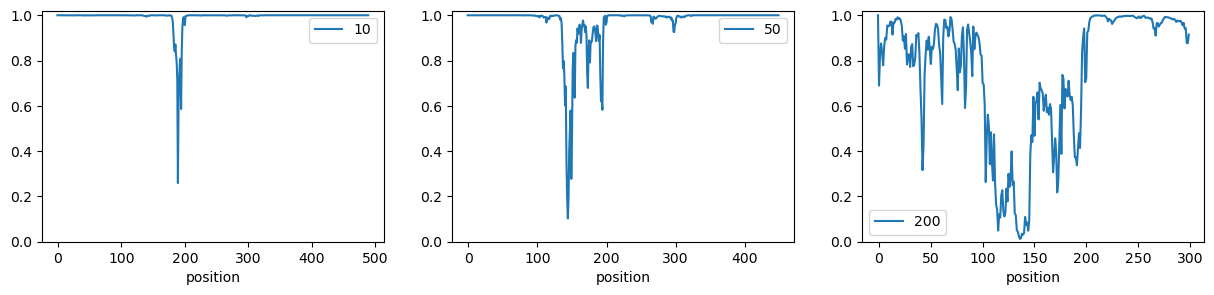


==== Sequence patch results: ======================================================================
MIFVKTQRGMEYIAMQNIKELMGDVKIEVRPAGYLGVLIVHSDDIEKVKEVPEVEKAIPILFELRSDLDEILGKAEEIVEAMGDFETFAVRTTRRGLRHDFNSMDVNIRLGRRIQEISGKEVDLNQPDKAVYVEIVNERTFIGILDGEEERRKYMPEKVDSLKFFGKVSFVQMPYLENPKGAREIGERIGRSAQSFEIKELIIAPYGYVDADELYEFLRGLRRGKESRLKIQRRSYARDVREVRVLVHDLYQTFRDKRRKRSVLISTDPTGKQLSEIREELKRAFERADEIVIFAGSRTGLPKGILRLSDFVIDLTPYITFPTEIAIPASLIALLDVYEEMVQEREQK

Calculating PATCH=10 results...
Min prediction (= 0.8493922352790833) for seq version was at interval (189, 199) (df row index = 190): MIFVKTQRGMEYIAMQNIKELMGDVKIEVRPAGYLGVLIVHSDDIEKVKEVPEVEKAIPILFELRSDLDEILGKAEEIVEAMGDFETFAVRTTRRGLRHDFNSMDVNIRLGRRIQEISGKEVDLNQPDKAVYVEIVNERTFIGILDGEEERRKYMPEKVDSLKFFGKVSFVQMPYLENPKGAREIGERIXXXXXXXXXXELIIAPYGYVDADELYEFLRGLRRGKESRLKIQRRSYARDVREVRVLVHDLYQTFRDKRRKRSVLISTDPTGKQLSEIREELKRAFERADEIVIFAGSRTGLPKGILRLSDFVIDLTPYITFPTEIAIPASLIALLDVYEEMVQEREQK
Patched subseq: GRSAQSFEIK

Calculating PATCH=50 results...
Min p

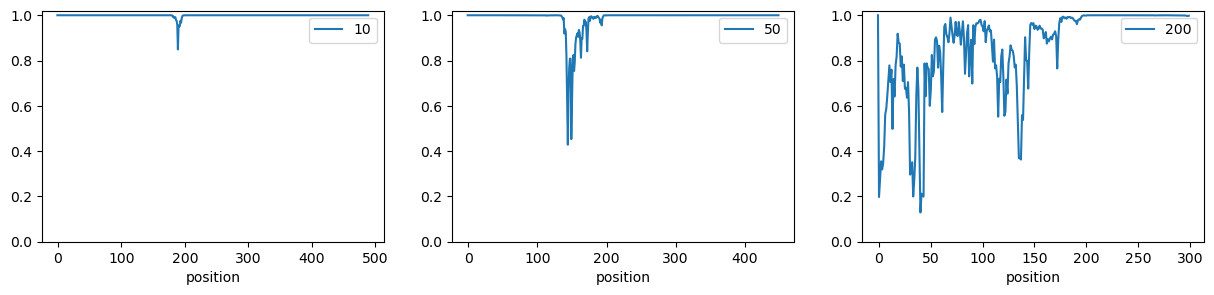


==== Sequence patch results: ======================================================================
MASRECQLLLVKTILGMERVAASYIAEMDPDARIEPAPRGFRGLVLVEASKDKYELAREIEAKVPEVEKVVVAEACTEADPAKIAETAAALAPRFISSNETFAVRTVRRGRHGFTSIDVNVVVGDAVRRATGAQVNLRYPDKVVAVEIIQDLALIAFYPGSREWRKMKPGKYPLYKLFRRFSIVQMPYLGPLDACRTMGVRVGREVQNFEVGELVVAPIGLVDARQLYEFLGGVFEGIESRYQIQRRSYGRDVRRVPVYVQDLYQLVRSRHGEPIIVFEPEGDPISKRAKDVLEIVKRGRRVTLLFGSREGIPEGVYRFADLVLDIAPGITLSTEYAAAAALIAIGSVVHDELAAEQVNGEDSAADKQPKDAA

Calculating PATCH=10 results...
Min prediction (= 0.9950441122055054) for seq version was at interval (204, 214) (df row index = 205): MASRECQLLLVKTILGMERVAASYIAEMDPDARIEPAPRGFRGLVLVEASKDKYELAREIEAKVPEVEKVVVAEACTEADPAKIAETAAALAPRFISSNETFAVRTVRRGRHGFTSIDVNVVVGDAVRRATGAQVNLRYPDKVVAVEIIQDLALIAFYPGSREWRKMKPGKYPLYKLFRRFSIVQMPYLGPLDACRTMGVRVGRXXXXXXXXXXVVAPIGLVDARQLYEFLGGVFEGIESRYQIQRRSYGRDVRRVPVYVQDLYQLVRSRHGEPIIVFEPEGDPISKRAKDVLEIVKRGRRVTLLFGSREGIPEGVYRFADLVLDIAPGITLSTEYAAAAALIAIGSVVHDELAAEQVNGEDSAADKQPKDAA
Patched subseq:

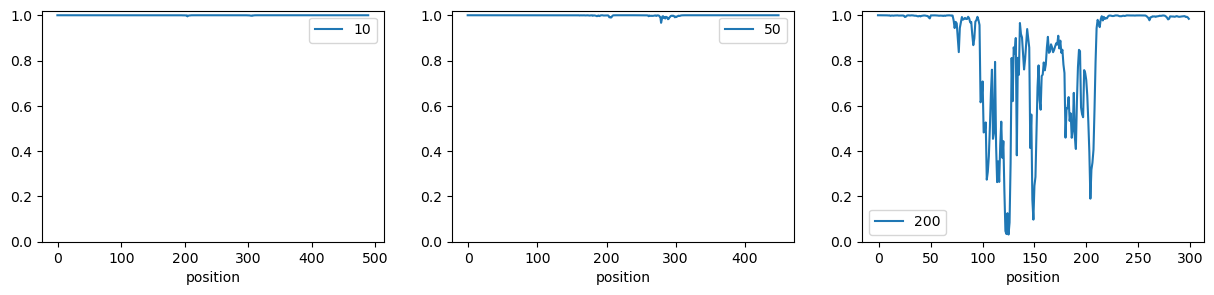


==== Sequence patch results: ======================================================================
MKFLIKTQKDMEAVAANYIKDLLDETEIWVTPQGYSGLVLVDTKDPKAEEKFFEIPEIERIIPVLFEVPASLDAIVSVAEEIADYISEEETFAVKTKRRGKHEFSSIDVNITLGEKIRELTNAAVDLSFPDKTVLVEIIGERAYISIAGKEEWKKFTPEKINARKLFKKVTIVQMPYWGDYKACKNFGEKIGRAVQAFEVKELIIAPKEKMNAYELMEFIKGIRTGQESRYQIQKEAYPWKVEKVPISVWDLYQVIRDKRRNKRLLIITDPKGNTIPEVKENLTKDLYYAKEVVVFIGSREGIPRGLFRYADYVLDLAPYMTFATEHGIPAVLIALWTIYEEELRKKGIKEE

Calculating PATCH=10 results...
Min prediction (= 0.9830073118209839) for seq version was at interval (184, 194) (df row index = 185): MKFLIKTQKDMEAVAANYIKDLLDETEIWVTPQGYSGLVLVDTKDPKAEEKFFEIPEIERIIPVLFEVPASLDAIVSVAEEIADYISEEETFAVKTKRRGKHEFSSIDVNITLGEKIRELTNAAVDLSFPDKTVLVEIIGERAYISIAGKEEWKKFTPEKINARKLFKKVTIVQMPYWGDYKACXXXXXXXXXXVQAFEVKELIIAPKEKMNAYELMEFIKGIRTGQESRYQIQKEAYPWKVEKVPISVWDLYQVIRDKRRNKRLLIITDPKGNTIPEVKENLTKDLYYAKEVVVFIGSREGIPRGLFRYADYVLDLAPYMTFATEHGIPAVLIALWTIYEEELRKKGIKEE
Patched subseq: KNFGEKIGRA

Calculating PATCH=50 results.

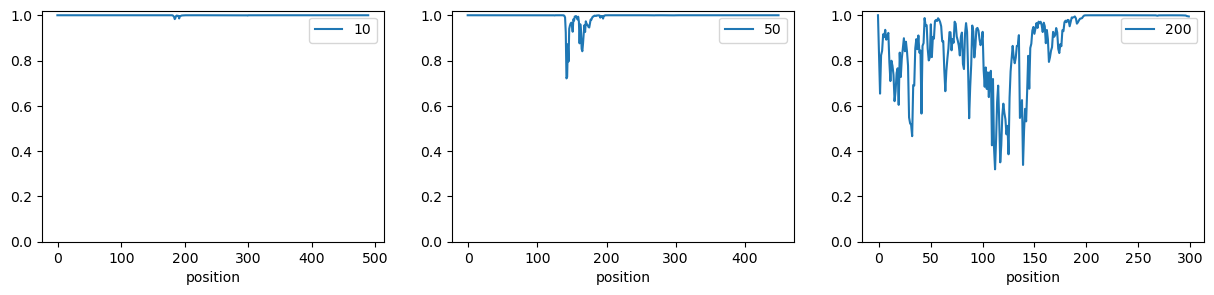


==== Sequence patch results: ======================================================================
MKFIVKTQRGMESVAANYIREAISDASVWASPMGYSGLIIVETSDENAGEKILEIPEVERLIPVIAEVPAELEAIVTTAEKIAPLISENETFAVKTKRRGKHGFTSMDVNRELGARIRELTNADVNLSWPDRVVQVEIIGDKAYISVVPGEEFRKFTPDKIDARKLFRKVTLVQMPYWGNHKACRSFGEKIGRAAQAFEVKELIIAPKEKMDAFELAEFIKGVKIGQESRHQIQREAYPWKVEKVPVSVWDLYQVVRDKRRGKRLLIITDPKGPTLAEVKDRLAKDMFYAKEVVIFVGSREGIPRGLFRFADYVVDLAPYMTFATEHGIPAALVSLWEVYEEYARKREKKT

Calculating PATCH=10 results...
Min prediction (= 0.3228438198566437) for seq version was at interval (185, 195) (df row index = 186): MKFIVKTQRGMESVAANYIREAISDASVWASPMGYSGLIIVETSDENAGEKILEIPEVERLIPVIAEVPAELEAIVTTAEKIAPLISENETFAVKTKRRGKHGFTSMDVNRELGARIRELTNADVNLSWPDRVVQVEIIGDKAYISVVPGEEFRKFTPDKIDARKLFRKVTLVQMPYWGNHKACRXXXXXXXXXXQAFEVKELIIAPKEKMDAFELAEFIKGVKIGQESRHQIQREAYPWKVEKVPVSVWDLYQVVRDKRRGKRLLIITDPKGPTLAEVKDRLAKDMFYAKEVVIFVGSREGIPRGLFRFADYVVDLAPYMTFATEHGIPAALVSLWEVYEEYARKREKKT
Patched subseq: SFGEKIGRAA

Calculating PATCH=50 results...

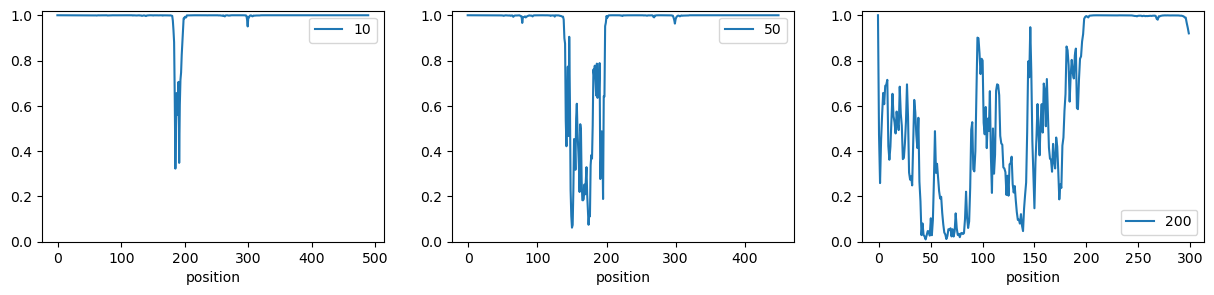


==== Sequence patch results: ======================================================================
MSECSVILVKTELGMERYVANSLDVDCEIVAAPMGFKGLVLMKNCKNLEEVIERLNGMPEVIRFMIAEECVRADLKELKEAAKRLARKLEGKRFAVRTIRRGSHPFTSIEVNAELGALILREANGSKVDLTNPEAVLMVEIIGEEAYLAVVDPSYAGLKKKLGKEDTARFLSRLSVIQEPYLGPPKSIEELGKRIGRILQSYGVGEYYIGLIEETDALQLAQFIESVRDGMEARRKQEEKVEGKALSTKLKVFDVYHLALSKSKKELMVVFEPEGKSFEEVEEELAKALRKAKRVKAFLGSRKGVPMGIYKLADFVIDVAPGRTLSTETALAAALEALLIAYLRGKFYSDNQQ

Calculating PATCH=10 results...
Min prediction (= 0.015866732224822044) for seq version was at interval (301, 311) (df row index = 302): MSECSVILVKTELGMERYVANSLDVDCEIVAAPMGFKGLVLMKNCKNLEEVIERLNGMPEVIRFMIAEECVRADLKELKEAAKRLARKLEGKRFAVRTIRRGSHPFTSIEVNAELGALILREANGSKVDLTNPEAVLMVEIIGEEAYLAVVDPSYAGLKKKLGKEDTARFLSRLSVIQEPYLGPPKSIEELGKRIGRILQSYGVGEYYIGLIEETDALQLAQFIESVRDGMEARRKQEEKVEGKALSTKLKVFDVYHLALSKSKKELMVVFEPEGKSFEEVEEELAKALRKAKRVKAFLGSXXXXXXXXXXLADFVIDVAPGRTLSTETALAAALEALLIAYLRGKFYSDNQQ
Patched subseq: RKGVPMGIYK

Calculating PATCH=50 resu

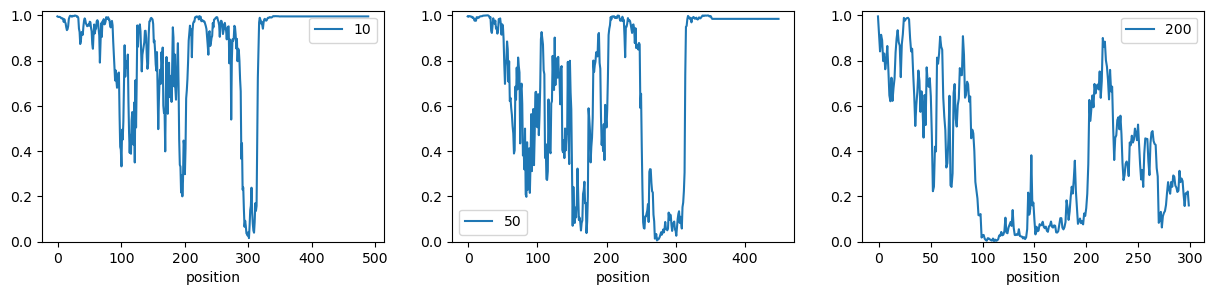


==== Sequence patch results: ======================================================================
MKFLIKTQRGMEAVAANYIKDALEDAKVWIAPQGYSGLVLVESEDKDAEQKLFDIPEIERVIPVLFEVPATIEDILSVSEQIAAYIKEGESFAVKTKRRGKHGFSSVDVNIALGGKIKELTNAEVDLTFPDKTVLVEIIGDRAYISITGREEWKKFTPEKIDARKLFKKVTIVQMPYWGDYKACRNFGEKIGRAAQAFEVKELIIAPKDKMDAYELMEFIQGVKIGQESRHQIQREAYPWKVEKVPVSVWDLYQVVRDKRRNKRLLIITDPKGNSVSEIKDSLAKDLYYAKEVVVFIGSREGIPRGLFRYADYVIDLAPYMTFATEHGIPAALIALWTIYEEELRKEEGKR

Calculating PATCH=10 results...
Min prediction (= 0.9658121466636658) for seq version was at interval (185, 195) (df row index = 186): MKFLIKTQRGMEAVAANYIKDALEDAKVWIAPQGYSGLVLVESEDKDAEQKLFDIPEIERVIPVLFEVPATIEDILSVSEQIAAYIKEGESFAVKTKRRGKHGFSSVDVNIALGGKIKELTNAEVDLTFPDKTVLVEIIGDRAYISITGREEWKKFTPEKIDARKLFKKVTIVQMPYWGDYKACRXXXXXXXXXXQAFEVKELIIAPKDKMDAYELMEFIQGVKIGQESRHQIQREAYPWKVEKVPVSVWDLYQVVRDKRRNKRLLIITDPKGNSVSEIKDSLAKDLYYAKEVVVFIGSREGIPRGLFRYADYVIDLAPYMTFATEHGIPAALIALWTIYEEELRKEEGKR
Patched subseq: NFGEKIGRAA

Calculating PATCH=50 results...

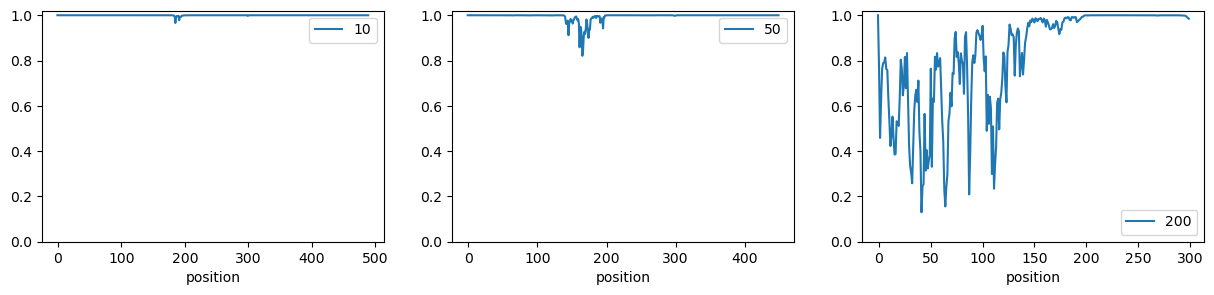


==== Sequence patch results: ======================================================================
MQGSKCNLVLMKTVLGMEKVAASYVKEIDPGARVEPSPRGFRGLVLVEPSRDKYEVAKEIEERVPEAEKVVVAEACTEADPRKIAEIAAELAPRFISSSETFAVRTVRRGRHGFTSIDVNVVVGDAVRRATGAQVNLRYPDKVVAVEIIQDLALIAFYPGSREWRKMRPGKYPLYKLFRRLSVVQMPYLGPLDACRTMGVRVGREVQNFEVGELVVSPIGLVDALQLKTFLDGVFEGIESRYQVQRKSYGRDVHRVPVYVQDLYQLVRSRYDEPVIVFEPEGDPISKRARDILELVRKGRRVNLLFGSREGIPEGVYRFADLVLDVAPGITLSTEYAAAAALIAIGSVIHDLLAVDREPAGEQGSRS

Calculating PATCH=10 results...
Min prediction (= 0.8443419933319092) for seq version was at interval (204, 214) (df row index = 205): MQGSKCNLVLMKTVLGMEKVAASYVKEIDPGARVEPSPRGFRGLVLVEPSRDKYEVAKEIEERVPEAEKVVVAEACTEADPRKIAEIAAELAPRFISSSETFAVRTVRRGRHGFTSIDVNVVVGDAVRRATGAQVNLRYPDKVVAVEIIQDLALIAFYPGSREWRKMRPGKYPLYKLFRRLSVVQMPYLGPLDACRTMGVRVGRXXXXXXXXXXVVSPIGLVDALQLKTFLDGVFEGIESRYQVQRKSYGRDVHRVPVYVQDLYQLVRSRYDEPVIVFEPEGDPISKRARDILELVRKGRRVNLLFGSREGIPEGVYRFADLVLDVAPGITLSTEYAAAAALIAIGSVIHDLLAVDREPAGEQGSRS
Patched subseq: EVQNFEVGEL


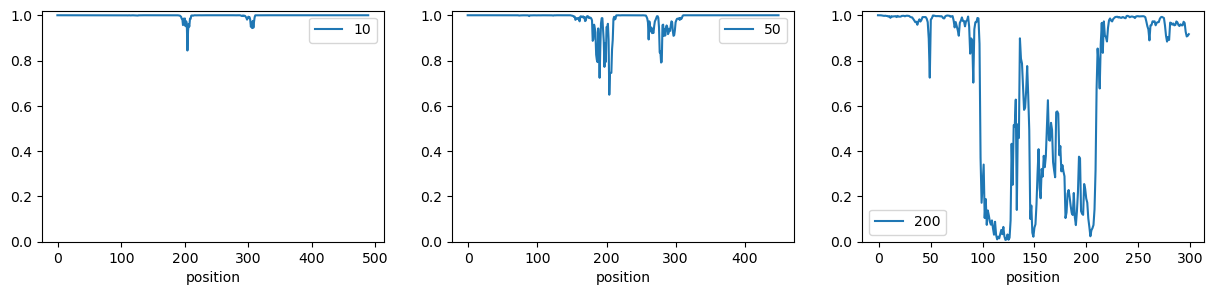


==== Sequence patch results: ======================================================================
MGEGKKFIVKTQRGMESVAANYISEVLPDANVWASPMGYSGLIIVESSAEDALDKILQIPEVERVIPVIVETEANLEKIAESAEKLAGFIGENETYAVKTKRRGKHDFSSIDVNRVLGAKIKELTNADVNLSWPDKVVQVEIIGDRAYISVIPGDEFRKYTPDKIDARKLFSKLTLVQMPYWGDYKACRLFGEKIGRAAQAFEVKELIIAPKEKMDAYELMEFIRGVKVGQESRYQIQRDAYPWKVEKVPVTVWDLYQVVRDKRRKKRLLIITDPKGPTLAEVKDKLARDLHYAKEVVVFIGSREGIPKGLFRFADYVVDLAPYMTFATEHGIPAALVSLWEVYEEFLRKEE

Calculating PATCH=10 results...
Min prediction (= 0.6560045480728149) for seq version was at interval (195, 205) (df row index = 196): MGEGKKFIVKTQRGMESVAANYISEVLPDANVWASPMGYSGLIIVESSAEDALDKILQIPEVERVIPVIVETEANLEKIAESAEKLAGFIGENETYAVKTKRRGKHDFSSIDVNRVLGAKIKELTNADVNLSWPDKVVQVEIIGDRAYISVIPGDEFRKYTPDKIDARKLFSKLTLVQMPYWGDYKACRLFGEKIXXXXXXXXXXELIIAPKEKMDAYELMEFIRGVKVGQESRYQIQRDAYPWKVEKVPVTVWDLYQVVRDKRRKKRLLIITDPKGPTLAEVKDKLARDLHYAKEVVVFIGSREGIPKGLFRFADYVVDLAPYMTFATEHGIPAALVSLWEVYEEFLRKEE
Patched subseq: GRAAQAFEVK

Calculating PATCH=50 results.

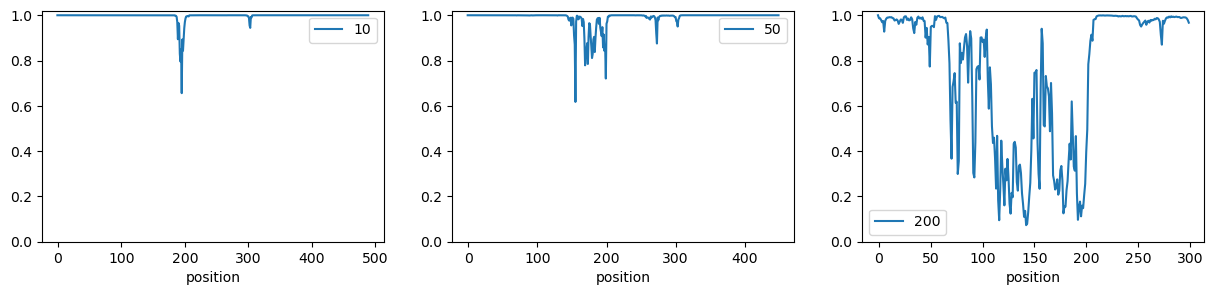


==== Sequence patch results: ======================================================================
MKFLVKTQKGMEGVAANYIGEALPDAEVWISPMGYYGLVIVETGDENAGEVMLGIPEIERIIPVLAEVPAELERIVEIAEKVAPLIGENETFAVKTKRRGKHGFSSIDVNRELGAKVRELTGADVNLSWPDKVVQVEIIGDRAYVSVLPGEEFRKFTPDKRDARELFRKVTVVQMPYWGGYKVCRSFGEKIGRAAQAFEVKELIIAPKGKMDALELAEFIKGVRVGQESRHRIQRESYPWKVEKVPVSVWDLYQVVRDKRRDKRLLIITDPKGPTVAQVGERLARDMFHAKEVVVFIGSREGIPRGLFRFADYVIDLAPYMTFATEHGIPAALVSLWEVYEEYTGKREAKGEAVSD

Calculating PATCH=10 results...
Min prediction (= 0.7244693040847778) for seq version was at interval (185, 195) (df row index = 186): MKFLVKTQKGMEGVAANYIGEALPDAEVWISPMGYYGLVIVETGDENAGEVMLGIPEIERIIPVLAEVPAELERIVEIAEKVAPLIGENETFAVKTKRRGKHGFSSIDVNRELGAKVRELTGADVNLSWPDKVVQVEIIGDRAYVSVLPGEEFRKFTPDKRDARELFRKVTVVQMPYWGGYKVCRXXXXXXXXXXQAFEVKELIIAPKGKMDALELAEFIKGVRVGQESRHRIQRESYPWKVEKVPVSVWDLYQVVRDKRRDKRLLIITDPKGPTVAQVGERLARDMFHAKEVVVFIGSREGIPRGLFRFADYVIDLAPYMTFATEHGIPAALVSLWEVYEEYTGKREAKGEAVSD
Patched subseq: SFGEKIGRAA

Calculating PATCH=50 

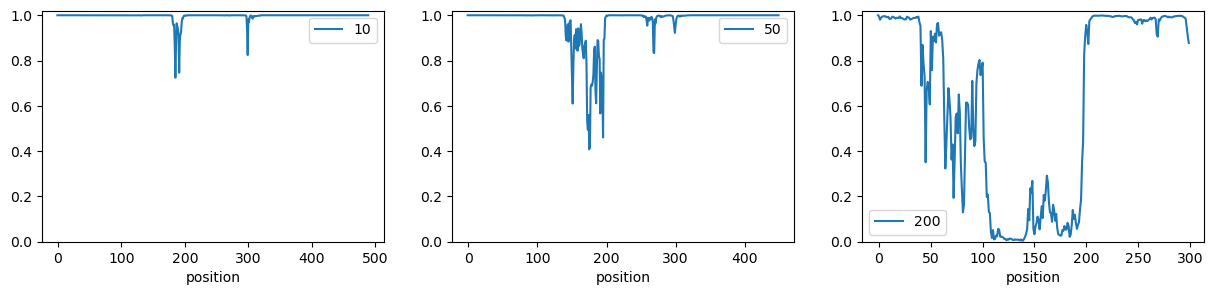


==== Sequence patch results: ======================================================================
MEFIIKTQKNLEGTAATRIKEKLKNAETWITPEGYSGLIILKTTDKEATKKLQEIPEIERTLPIHYKTGSNLEKILEKAEKIAKHIKENETFAVKTKRRGKHNFTSPEINKKLGEKILQLTNATVNLNSPDKTIQIEIIGENTYISIRKKEKWKKYTPEKEDARKLFNKTTIIQMPYWGKPQIARKFGEKIGRAAQAYEIKELIIAPKEKMNAQEIAEFIKGVKKGQQSRYKIQKEAYPWPTKKVPISLWDIYQATRDKKRKKRTIIITDPKGKTINAIKENLQKDLRKSKEIIILIGSREGIPRGLFKFADYIIDLTPYITFATEHVIPATLTTLYQLYSKEGQT

Calculating PATCH=10 results...
Min prediction (= 0.47213953733444214) for seq version was at interval (299, 309) (df row index = 300): MEFIIKTQKNLEGTAATRIKEKLKNAETWITPEGYSGLIILKTTDKEATKKLQEIPEIERTLPIHYKTGSNLEKILEKAEKIAKHIKENETFAVKTKRRGKHNFTSPEINKKLGEKILQLTNATVNLNSPDKTIQIEIIGENTYISIRKKEKWKKYTPEKEDARKLFNKTTIIQMPYWGKPQIARKFGEKIGRAAQAYEIKELIIAPKEKMNAQEIAEFIKGVKKGQQSRYKIQKEAYPWPTKKVPISLWDIYQATRDKKRKKRTIIITDPKGKTINAIKENLQKDLRKSKEIIILIGSXXXXXXXXXXFADYIIDLTPYITFATEHVIPATLTTLYQLYSKEGQT
Patched subseq: REGIPRGLFK

Calculating PATCH=50 results...
Min pred

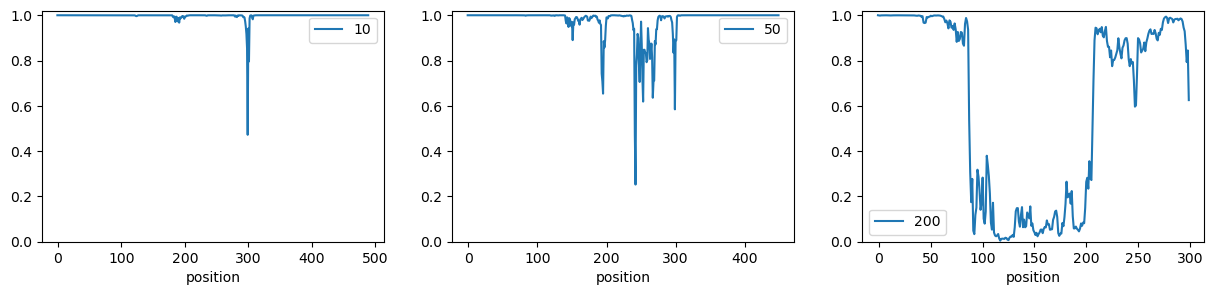


==== Sequence patch results: ======================================================================
MSIFKYLQQLLVVSSMSGVDLIIKTRKEFERVAASHIKELLGPGAEAVSAPWGYLGIVFVKGLGADRWKAAELIAEKIPEVDRVLVVEEAVKADLPEIEKAAVEVARRYIQSGDTFAIRTTRRGRHGFTSIDVNVRVGAAVKEATGAEVDLEEPTKPLYIEIFQDTAAICVPATREYKKLRRDKPLPLQFFRKVAIGQLVYEGDEEAVRKMGERIGRAVQTFEVGELAVLLHKPMPSKSLGTFLEAVEAGIESRYQIQARSYGRPVWKVPVYVYELYQYIRSREGEPIVVTDPKGDYITHVKEELAQLFRRDRVNVLIGSREGIPTGVFRLASLVVDLVPEVTIATDFVVPSLAVALVSALEEAGALPRYVGKRRKH

Calculating PATCH=10 results...
Min prediction (= 0.9521101117134094) for seq version was at interval (215, 225) (df row index = 216): MSIFKYLQQLLVVSSMSGVDLIIKTRKEFERVAASHIKELLGPGAEAVSAPWGYLGIVFVKGLGADRWKAAELIAEKIPEVDRVLVVEEAVKADLPEIEKAAVEVARRYIQSGDTFAIRTTRRGRHGFTSIDVNVRVGAAVKEATGAEVDLEEPTKPLYIEIFQDTAAICVPATREYKKLRRDKPLPLQFFRKVAIGQLVYEGDEEAVRKMGERIXXXXXXXXXXELAVLLHKPMPSKSLGTFLEAVEAGIESRYQIQARSYGRPVWKVPVYVYELYQYIRSREGEPIVVTDPKGDYITHVKEELAQLFRRDRVNVLIGSREGIPTGVFRLASLVVDLVPEVTIATDFVVPSLAVALVSALEEAGALPRYVGKRRKH
Patched

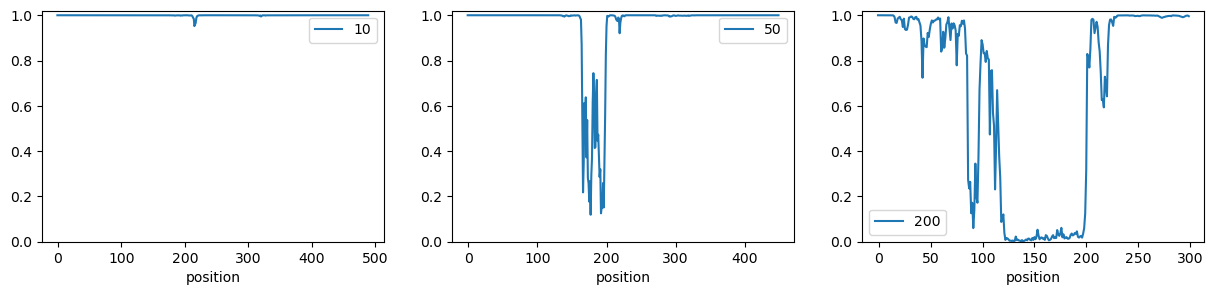


==== Sequence patch results: ======================================================================
MKFIVKTQMDMEAVAGNYIKEILPNAKVTTAPEGYPGIVIVEAEDENALQKILEVPEVEKVYPVLVEVPATLEDIKNSAEEIVRHINDGESFAVRTKKRGKKDFSSVDVNVVLGARIKDLKNVEVNLSYPDKVVQVEIIGDKAYISVIPGEEYMKWKKYPKEKPNCRKLFKKLTIVQMPYWGDYKTARAFGEKIGRAAQAFEVKELIIAPKEKMNAYELMAFIRGVKEGQESRYQIQREAYPWQVEKVPVTVWDLYQVIRDKRRNRRLIIITDPKGPTLNEVKDKLAKDMYYAKEVVVFIGSREGIPVGLFRFADYVVDLAPYMTFATEHGIPATLVALWTIYEEELRRRGEVAGED

Calculating PATCH=10 results...
Min prediction (= 0.8376880288124084) for seq version was at interval (188, 198) (df row index = 189): MKFIVKTQMDMEAVAGNYIKEILPNAKVTTAPEGYPGIVIVEAEDENALQKILEVPEVEKVYPVLVEVPATLEDIKNSAEEIVRHINDGESFAVRTKKRGKKDFSSVDVNVVLGARIKDLKNVEVNLSYPDKVVQVEIIGDKAYISVIPGEEYMKWKKYPKEKPNCRKLFKKLTIVQMPYWGDYKTARXXXXXXXXXXQAFEVKELIIAPKEKMNAYELMAFIRGVKEGQESRYQIQREAYPWQVEKVPVTVWDLYQVIRDKRRNRRLIIITDPKGPTLNEVKDKLAKDMYYAKEVVVFIGSREGIPVGLFRFADYVVDLAPYMTFATEHGIPATLVALWTIYEEELRRRGEVAGED
Patched subseq: AFGEKIGRAA

Calculating PATCH=5

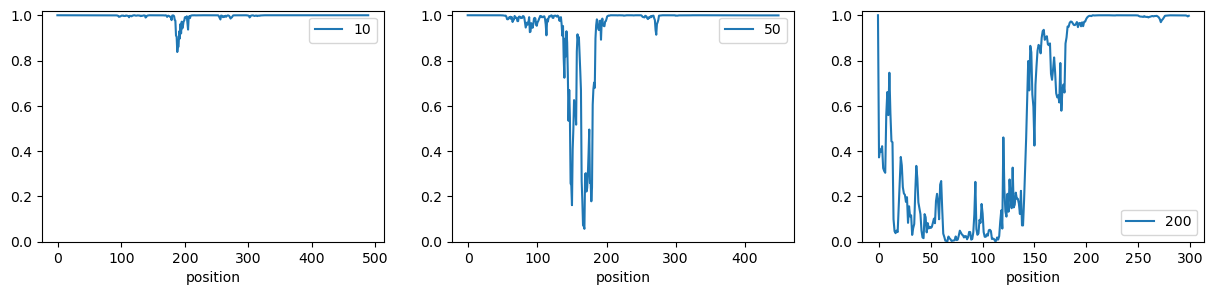


==== Sequence patch results: ======================================================================
MEKIVCSRIQENFEKTGNVVPKPSGFMGIVISEICGKKKEEIKEIPEVENVVPIVEEVSQPNLEKISKLCRKVAEELPDGSRFAVDADRRGTHEFTSQEIEAKAGSEIMKLVGSLEVELDRPDFVVKVEVIEQWAGVGILEGGEILRKKVGKADSRELTAKIHLVQLVYRGKDRRGIERIGVSLGRSAQAFETKKVTIVFDSPTDADKLQAFLNGIDEGIDSRFRIQKRVYERSMSRVPVDVYELYQFLRKIDGEEDLVIMTDPRGEVLQNSRNNLKEDLKSAETVYLFNGSNKGIPTGCFERADHVLDLAPHITYATDQAITASVIALLNL

Calculating PATCH=10 results...
Min prediction (= 0.470146507024765) for seq version was at interval (131, 141) (df row index = 132): MEKIVCSRIQENFEKTGNVVPKPSGFMGIVISEICGKKKEEIKEIPEVENVVPIVEEVSQPNLEKISKLCRKVAEELPDGSRFAVDADRRGTHEFTSQEIEAKAGSEIMKLVGSLEVELDRPDFVVKVEVIXXXXXXXXXXGGEILRKKVGKADSRELTAKIHLVQLVYRGKDRRGIERIGVSLGRSAQAFETKKVTIVFDSPTDADKLQAFLNGIDEGIDSRFRIQKRVYERSMSRVPVDVYELYQFLRKIDGEEDLVIMTDPRGEVLQNSRNNLKEDLKSAETVYLFNGSNKGIPTGCFERADHVLDLAPHITYATDQAITASVIALLNL
Patched subseq: EQWAGVGILE

Calculating PATCH=50 results...
Min prediction (= 0.1392388939857483) 

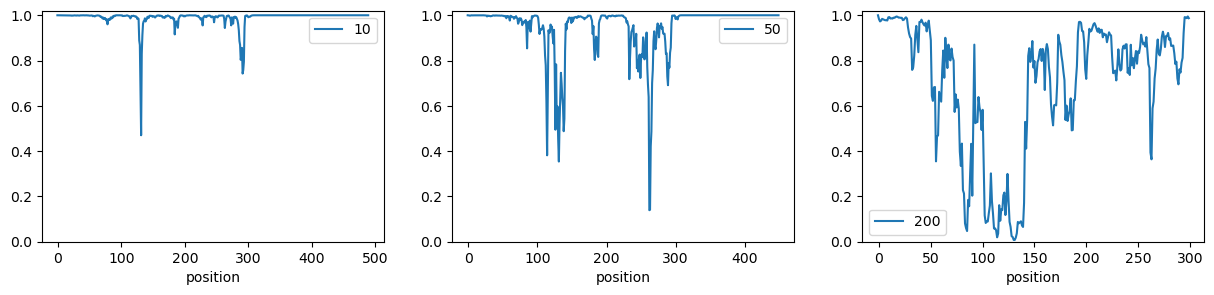


==== Sequence patch results: ======================================================================
MKFLVKTQKGMESVAGNYIREALPNAEVWASPMGYSGLVIVETNDENAEEKILEIPEVERVIPVLVETNAELGEIVKAANEIASLISKDETFAVKTKRRGKHDFSSIDVNRVLGAKIKELTDADVNLSWPDKVVQVEIIGDRAFISVLPGEEYRKYTPDKFDARKLLSKVTLVQMPYWGDYKACRKFGEKIGRAAQAFEVKELIIAPKEKMDAYELMEFLRGIKTGQESRYQIQREAYPWKVEKVPVSVWDLYQVVRDKRRNKRLLIITDPKGPTLAEVKEKLARDMHYAKEVVIFIGSREGIPRGLFRFADYVIDLAPYMTFATEHGIPATLVSLWEVYEEFLRKSEEKAEAPS

Calculating PATCH=10 results...
Min prediction (= 0.39513036608695984) for seq version was at interval (299, 309) (df row index = 300): MKFLVKTQKGMESVAGNYIREALPNAEVWASPMGYSGLVIVETNDENAEEKILEIPEVERVIPVLVETNAELGEIVKAANEIASLISKDETFAVKTKRRGKHDFSSIDVNRVLGAKIKELTDADVNLSWPDKVVQVEIIGDRAFISVLPGEEYRKYTPDKFDARKLLSKVTLVQMPYWGDYKACRKFGEKIGRAAQAFEVKELIIAPKEKMDAYELMEFLRGIKTGQESRYQIQREAYPWKVEKVPVSVWDLYQVVRDKRRNKRLLIITDPKGPTLAEVKEKLARDMHYAKEVVIFIGSXXXXXXXXXXFADYVIDLAPYMTFATEHGIPATLVSLWEVYEEFLRKSEEKAEAPS
Patched subseq: REGIPRGLFR

Calculating PATCH=50 r

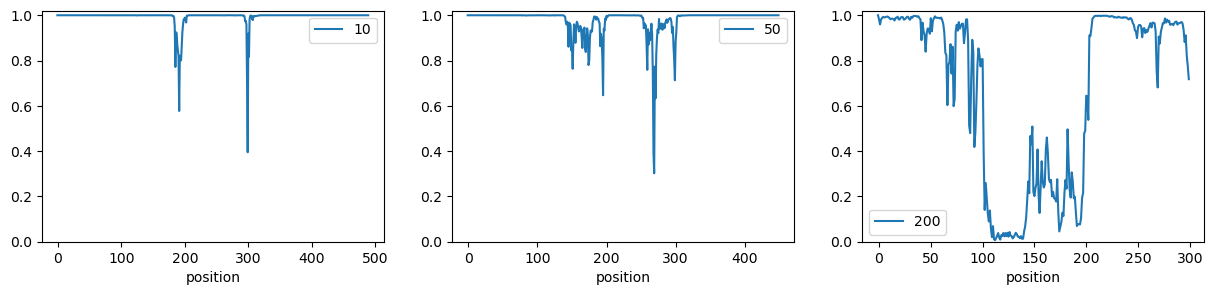


==== Sequence patch results: ======================================================================
MPCERVLAIVKTVLGMEEVAASVIEETVGVRCVAKPNGYPGIVLVCGDGERSEVVDRIRSEVPEAERVIPVEEWVPSDIDSIVEAAKRVVDGRIGADESFAVRTVRRGRRGYTSVDVNIRAGAVVKEVTGASVNLRYPDKIVQVEILGDHAAVSLLDGRMEWRKLRPGKPAVLDFIRKVAVAHIPYLGPPNASREMGVRVGREAQTFEVKELVVTPVGLTDADSLRHFLNGVFEGIRSRFEIQKRAYGRDVHKVQVHLQDIYGFVRERRREPIIVFEPEGEPVPKVADEIYKLLQARRRVNVMVGSRVGIPLGIYRFADLVVDLCPGVTIATDYALTAGVIAFANIIEAKLIGEEG

Calculating PATCH=10 results...
Min prediction (= 0.5361135005950928) for seq version was at interval (192, 202) (df row index = 193): MPCERVLAIVKTVLGMEEVAASVIEETVGVRCVAKPNGYPGIVLVCGDGERSEVVDRIRSEVPEAERVIPVEEWVPSDIDSIVEAAKRVVDGRIGADESFAVRTVRRGRRGYTSVDVNIRAGAVVKEVTGASVNLRYPDKIVQVEILGDHAAVSLLDGRMEWRKLRPGKPAVLDFIRKVAVAHIPYLGPPNAXXXXXXXXXXEAQTFEVKELVVTPVGLTDADSLRHFLNGVFEGIRSRFEIQKRAYGRDVHKVQVHLQDIYGFVRERRREPIIVFEPEGEPVPKVADEIYKLLQARRRVNVMVGSRVGIPLGIYRFADLVVDLCPGVTIATDYALTAGVIAFANIIEAKLIGEEG
Patched subseq: SREMGVRVGR

Calculating PATCH=50 

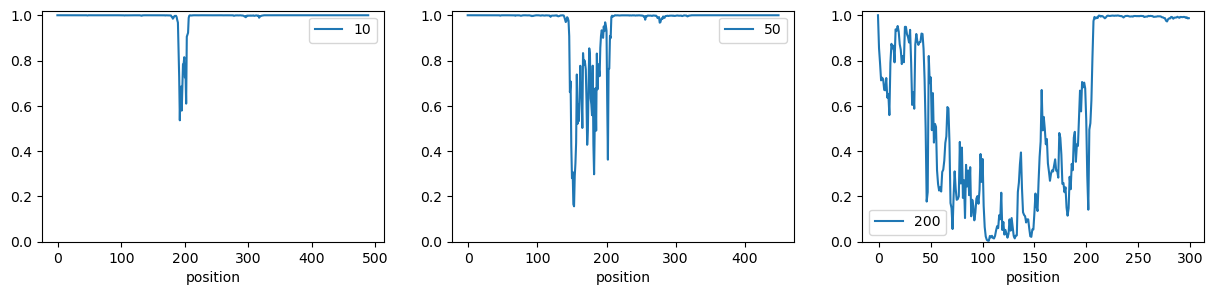


==== Sequence patch results: ======================================================================
MKALPSRRFDLIVKTPIGLERIAASRIEDLGLEGEVHSRPSGYPGIVTVTLRREDDKTHIAERIEREVPEAERVLVSRMSTAATIEEITDAAVKVASGAIRDGDSFAVRTVRRGRHPYTSVDVNRTVGSAVLESTGASVNLDHPDKILWVEIIDDQAAIGIIDGSEVWRKMKPGKWEVRTFLSKASVIQMPYLGDEKSARSMGSRIGRAVQMFEVGEFVIATMGVCDARRLAWFMDGVFEGIDSRYRIQCRTYAHRPRRVEVLVQDVYQLVRDRRAEPKIIFEPEGEVFPKVSSKIADLFLKADRRINLLFGSREGIPKGLFRFADLIVDLCPGITLSTEYAASSALIGISFALHNLMEQLNE

Calculating PATCH=10 results...
Min prediction (= 0.8253604769706726) for seq version was at interval (313, 323) (df row index = 314): MKALPSRRFDLIVKTPIGLERIAASRIEDLGLEGEVHSRPSGYPGIVTVTLRREDDKTHIAERIEREVPEAERVLVSRMSTAATIEEITDAAVKVASGAIRDGDSFAVRTVRRGRHPYTSVDVNRTVGSAVLESTGASVNLDHPDKILWVEIIDDQAAIGIIDGSEVWRKMKPGKWEVRTFLSKASVIQMPYLGDEKSARSMGSRIGRAVQMFEVGEFVIATMGVCDARRLAWFMDGVFEGIDSRYRIQCRTYAHRPRRVEVLVQDVYQLVRDRRAEPKIIFEPEGEVFPKVSSKIADLFLKADRRINLLFGSXXXXXXXXXXFADLIVDLCPGITLSTEYAASSALIGISFALHNLMEQLNE
Patched subseq: REGIPKGLFR

Calcula

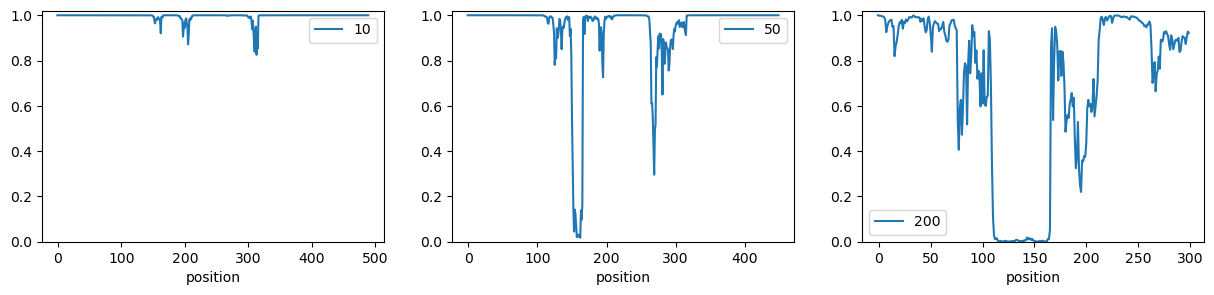


==== Sequence patch results: ======================================================================
MKFLVKTQRGMESVTANYIREALPDAEVWASPMGYSGLVIVETDDRSAEEKILEIPEVERAIKVLFEVPAELEAILSVAEDVAKLIRENETFAVKTKRRGKHDFSSLDVNAQLGAKIKELTNADVNLSWPDKVVQVEIIGDKAYISLLPGEEYRKFTPDKINARKLFRKVTLVQMPYWGDYKACRSFGEKIGRAAQAFEVRELIIAPKEKMDAFELMEFIKGVRVGQESRYQIQREAYPWKVEKVPVSVWDLYQVVRDKRRNKRLLIITDPKGPSLAEVKDKLARDMYYAKEVVIFVGSREGIPRGLFRFADYVVDLAPYMTFATEHGIPAALVSMWEIYEEYSRTREGEE

Calculating PATCH=10 results...
Min prediction (= 0.6776414513587952) for seq version was at interval (185, 195) (df row index = 186): MKFLVKTQRGMESVTANYIREALPDAEVWASPMGYSGLVIVETDDRSAEEKILEIPEVERAIKVLFEVPAELEAILSVAEDVAKLIRENETFAVKTKRRGKHDFSSLDVNAQLGAKIKELTNADVNLSWPDKVVQVEIIGDKAYISLLPGEEYRKFTPDKINARKLFRKVTLVQMPYWGDYKACRXXXXXXXXXXQAFEVRELIIAPKEKMDAFELMEFIKGVRVGQESRYQIQREAYPWKVEKVPVSVWDLYQVVRDKRRNKRLLIITDPKGPSLAEVKDKLARDMYYAKEVVIFVGSREGIPRGLFRFADYVVDLAPYMTFATEHGIPAALVSMWEIYEEYSRTREGEE
Patched subseq: SFGEKIGRAA

Calculating PATCH=50 results...

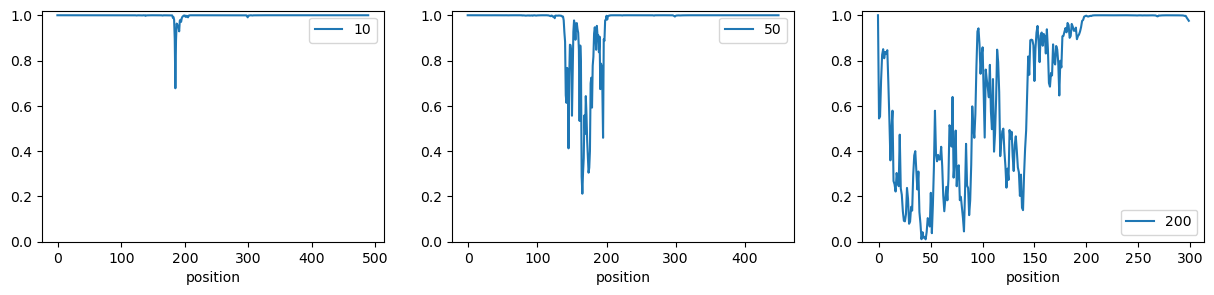


==== Sequence patch results: ======================================================================
MKFIVKTQRGMESVAANYIKESLPDARVWASPMGYYGLVIVETDEEKAAGKILEIPEVERLIPVIVEVPAELEKIVESAEKLAPMIRESETFAVKTKRRGKHGFTSMDVNRELGARIRELTNADVNLSWPDKVVQVEIIGDRAYISVVPGEEFRKFTPDKIDARKLFRKVTLVQMPYWGDYKACRSFGEKIGRAAQAFEVKELIIAPKEKMDAFELAEFIKGVRIGQESRYQIQREAYPWKVEKVPVSVWDLYQVVRDKRRGKRLLIITDPKGPTLAEVKENLAKDMFYSKEVVIFVGSREGIPRGLFRFADYVVDLAPYMTFATEHGIPAALVSLWEVYEEYARKREEKA

Calculating PATCH=10 results...
Min prediction (= 0.7669931054115295) for seq version was at interval (185, 195) (df row index = 186): MKFIVKTQRGMESVAANYIKESLPDARVWASPMGYYGLVIVETDEEKAAGKILEIPEVERLIPVIVEVPAELEKIVESAEKLAPMIRESETFAVKTKRRGKHGFTSMDVNRELGARIRELTNADVNLSWPDKVVQVEIIGDRAYISVVPGEEFRKFTPDKIDARKLFRKVTLVQMPYWGDYKACRXXXXXXXXXXQAFEVKELIIAPKEKMDAFELAEFIKGVRIGQESRYQIQREAYPWKVEKVPVSVWDLYQVVRDKRRGKRLLIITDPKGPTLAEVKENLAKDMFYSKEVVIFVGSREGIPRGLFRFADYVVDLAPYMTFATEHGIPAALVSLWEVYEEYARKREEKA
Patched subseq: SFGEKIGRAA

Calculating PATCH=50 results...

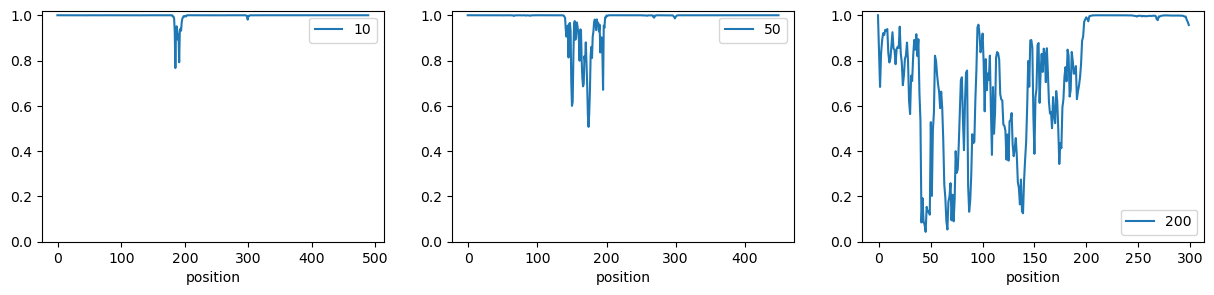


==== Sequence patch results: ======================================================================
MKFIVKTQRGMEGVAANYVKEALPDAKIWISPMGYSGLVIVEAGDEGAGERILEIPEVERIIPVLVEVPAELEAIVSSAEKIASLIGEDETFAVKTKRRGKHGFTSVDVNRELGARIRELTNSDVNLSWPDKVVQVEIIGDRAYVSVLPGEEFRKFTPDKIDARKLFRKVTLVQMPYWGDYKACRSFGEKIGRAAQAFEVKELIIAPKEKMDAFELAEFLKGVRIGQESRHRIQREAYPWKVEKVPVSVWDLYQVVRDKRRPKRLLIITDPKGPTLAEVKADLARDAFYAKEVVIFVGSREGIPRGLFRFADYVVDLAPYMTFATEHGIPAALVSLWEIYEEYARNLEEGD

Calculating PATCH=10 results...
Min prediction (= 0.955511212348938) for seq version was at interval (185, 195) (df row index = 186): MKFIVKTQRGMEGVAANYVKEALPDAKIWISPMGYSGLVIVEAGDEGAGERILEIPEVERIIPVLVEVPAELEAIVSSAEKIASLIGEDETFAVKTKRRGKHGFTSVDVNRELGARIRELTNSDVNLSWPDKVVQVEIIGDRAYVSVLPGEEFRKFTPDKIDARKLFRKVTLVQMPYWGDYKACRXXXXXXXXXXQAFEVKELIIAPKEKMDAFELAEFLKGVRIGQESRHRIQREAYPWKVEKVPVSVWDLYQVVRDKRRPKRLLIITDPKGPTLAEVKADLARDAFYAKEVVIFVGSREGIPRGLFRFADYVVDLAPYMTFATEHGIPAALVSLWEIYEEYARNLEEGD
Patched subseq: SFGEKIGRAA

Calculating PATCH=50 results...


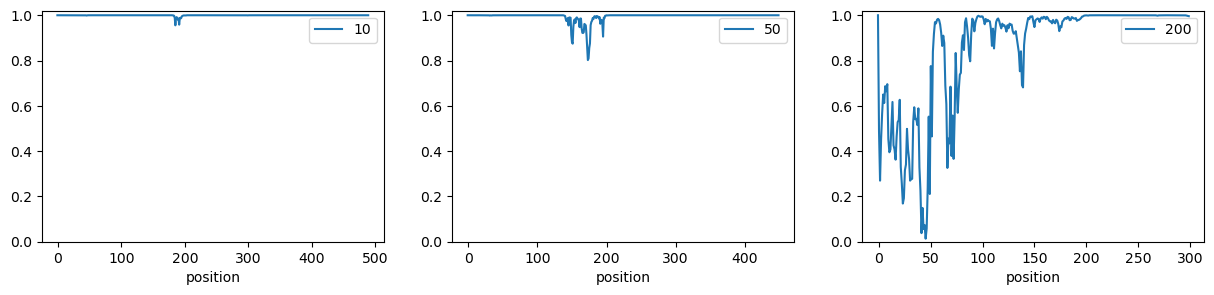


==== Sequence patch results: ======================================================================
MKFIVKTQRGMEGVAANYIREALPNSKVQASPLGYYGLVIVESDDENAVEKILEIPEVERVIPVLVEVPAEIEEIVNAAENVAPFIGENETFAVKTKRRGKHGFSSLDVNRSLGAKVQELTGADVNLSWPDKVVQVEIIGDKAYISVVPGEEFRKFTPDKIDARELFRKLTVVQMPYWGDYKACRSFGEKIGRAAQAFEVKELIIAPKEKMDAFELAEFIKGVKIGQESRHQIQREAYPWKVEKVPVSVWDLYQVVRDKRRAKRLLIITDPKGPTLAEVKDNLARDMFHAKEIIVFVGSREGIPRGLFRFADYVVDLAPYMTFATEHGIPAALVSLWEVYEEYLRSREKE

Calculating PATCH=10 results...
Min prediction (= 0.0037655106279999018) for seq version was at interval (185, 195) (df row index = 186): MKFIVKTQRGMEGVAANYIREALPNSKVQASPLGYYGLVIVESDDENAVEKILEIPEVERVIPVLVEVPAEIEEIVNAAENVAPFIGENETFAVKTKRRGKHGFSSLDVNRSLGAKVQELTGADVNLSWPDKVVQVEIIGDKAYISVVPGEEFRKFTPDKIDARELFRKLTVVQMPYWGDYKACRXXXXXXXXXXQAFEVKELIIAPKEKMDAFELAEFIKGVKIGQESRHQIQREAYPWKVEKVPVSVWDLYQVVRDKRRAKRLLIITDPKGPTLAEVKDNLARDMFHAKEIIVFVGSREGIPRGLFRFADYVVDLAPYMTFATEHGIPAALVSLWEVYEEYLRSREKE
Patched subseq: SFGEKIGRAA

Calculating PATCH=50 results..

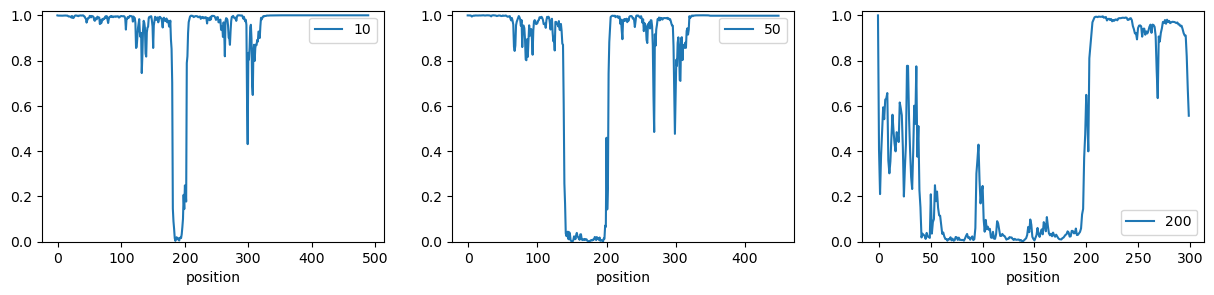


==== Sequence patch results: ======================================================================
MKFIVKTQRGLEGVAAGYIRETLPDAEVWASPMGYSGLVIVESEDGNAAERILEIPEVERAIPVLVEVPAELEAIVDTAGKIAPLIKEEETFAVRTKRRGKHDFSSVDVNRELGARIRELTNSDVNLSWPDRVVQVEIIGDRAYVSLLPGEEFRKFTPGKIDARKLFQKVVLVQMPYWGDYRACRSFGEKIGRAAQAFEVKELIIAPKEKMDAFELAEFLKGVKIGQESRHRIQSEAYPWKVEKVPVSLWDLYQVVRDKRRKKRLLIITDPKGPTLAGVKDELARDLFHSKEVVIFIGSREGIPRGLFRFADYVVDLAPYMTFATEHGIPAALVSLWEVYEEYLRKKP

Calculating PATCH=10 results...
Min prediction (= 0.8362175822257996) for seq version was at interval (185, 195) (df row index = 186): MKFIVKTQRGLEGVAAGYIRETLPDAEVWASPMGYSGLVIVESEDGNAAERILEIPEVERAIPVLVEVPAELEAIVDTAGKIAPLIKEEETFAVRTKRRGKHDFSSVDVNRELGARIRELTNSDVNLSWPDRVVQVEIIGDRAYVSLLPGEEFRKFTPGKIDARKLFQKVVLVQMPYWGDYRACRXXXXXXXXXXQAFEVKELIIAPKEKMDAFELAEFLKGVKIGQESRHRIQSEAYPWKVEKVPVSLWDLYQVVRDKRRKKRLLIITDPKGPTLAGVKDELARDLFHSKEVVIFIGSREGIPRGLFRFADYVVDLAPYMTFATEHGIPAALVSLWEVYEEYLRKKP
Patched subseq: SFGEKIGRAA

Calculating PATCH=50 results...
Min p

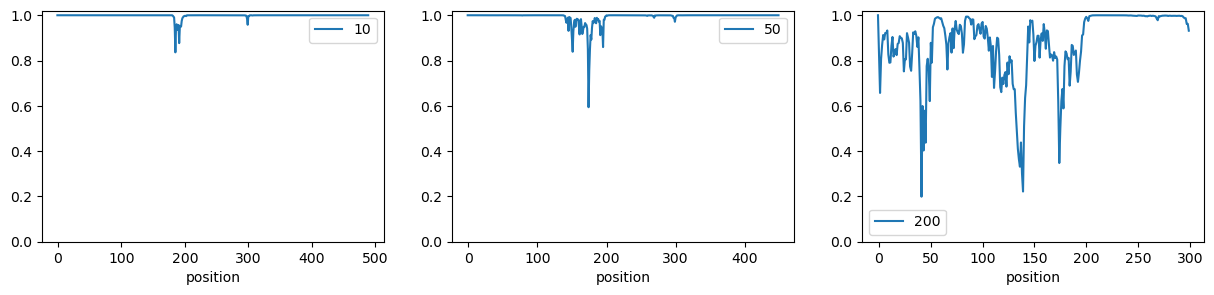


==== Sequence patch results: ======================================================================
MVWIEIFHDEAFISITSGSEERKKSYPGKPNLRQVPKRIVIGQVPYVGDIEAVRRMGIRIGRAAQTFEIKSLYVTPFRPLEGFILKTFLDGVYEGIKSRYEIQKKAYSVKPHRVPVYVYDLYQFVRLKCDKPIIVTSTRGKPLVTVKDSIIDLFSKHKEIIILIGAHEGLPTGLFRAAELVIDLAPGITISTDNALTSAVIGLVTVLEESKIG

Calculating PATCH=10 results...
Min prediction (= 0.4577030837535858) for seq version was at interval (149, 159) (df row index = 150): MVWIEIFHDEAFISITSGSEERKKSYPGKPNLRQVPKRIVIGQVPYVGDIEAVRRMGIRIGRAAQTFEIKSLYVTPFRPLEGFILKTFLDGVYEGIKSRYEIQKKAYSVKPHRVPVYVYDLYQFVRLKCDKPIIVTSTRGKPLVTVKDSXXXXXXXXXXIIILIGAHEGLPTGLFRAAELVIDLAPGITISTDNALTSAVIGLVTVLEESKIG
Patched subseq: IIDLFSKHKE

Calculating PATCH=50 results...
Min prediction (= 0.030147507786750793) for seq version was at interval (64, 114) (df row index = 65): MVWIEIFHDEAFISITSGSEERKKSYPGKPNLRQVPKRIVIGQVPYVGDIEAVRRMGIRIGRAAXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXPVYVYDLYQFVRLKCDKPIIVTSTRGKPLVTVKDSIIDLFSKHKEIIILIGAHEGLPT

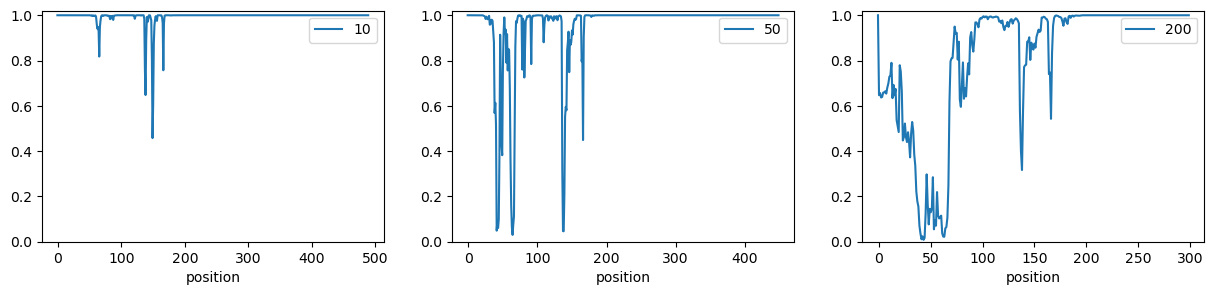


==== Sequence patch results: ======================================================================
MMEKTTIIVKTHKNLERIAASYIRDLIPDSEVLVKPNGYAGIILLKVKSVDAQTLKTTLITIPEIEKILFVRKCVEANLDRICEAVRHLARVSLKENEKFAVHTVRRGNHPFTSIDVNIKVGTCIQQETQCKVDLTLPDKIFWIEIIDNKAYISIVSRDIFYRKKTPDKLDNMKYLKKTIIVQMPYLDEIASSKIGVRIGRIVQSYEIPSIIVAPIYRVNAKELMYFLQGIHEGIMSRYKLQLKTYNDRKVSKTRVYLHDLYQLVRNINRDKEGIIITTTKGQPIKEETITKVKSLYMDKKKVYVFIGSREGIPTGLFKFADILLDVAPQITLATDVAVSSIISAILNMLLL

Calculating PATCH=10 results...
Min prediction (= 0.0006762816337868571) for seq version was at interval (309, 319) (df row index = 310): MMEKTTIIVKTHKNLERIAASYIRDLIPDSEVLVKPNGYAGIILLKVKSVDAQTLKTTLITIPEIEKILFVRKCVEANLDRICEAVRHLARVSLKENEKFAVHTVRRGNHPFTSIDVNIKVGTCIQQETQCKVDLTLPDKIFWIEIIDNKAYISIVSRDIFYRKKTPDKLDNMKYLKKTIIVQMPYLDEIASSKIGVRIGRIVQSYEIPSIIVAPIYRVNAKELMYFLQGIHEGIMSRYKLQLKTYNDRKVSKTRVYLHDLYQLVRNINRDKEGIIITTTKGQPIKEETITKVKSLYMDKKKVYVFIGSXXXXXXXXXXFADILLDVAPQITLATDVAVSSIISAILNMLLL
Patched subseq: REGIPTGLFK

Calculating PATCH=50 resul

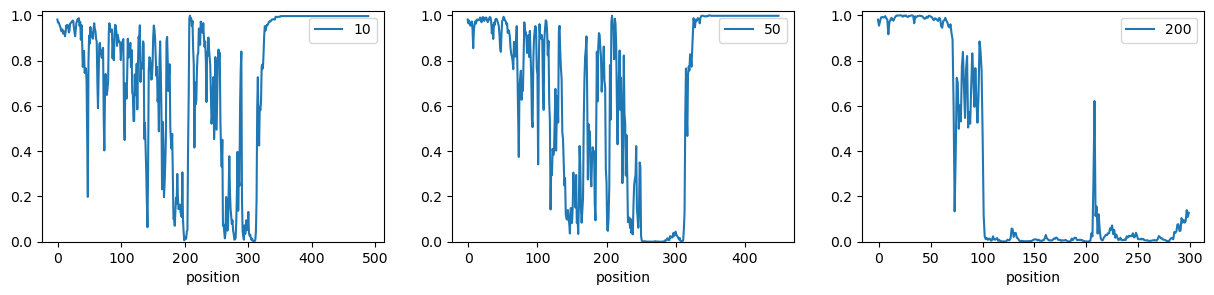


==== Sequence patch results: ======================================================================
MLLVKTQRGLEYIAASYIKDELGDVKLEVRPGGFLGLILVYSDELEKIKGIPEIETIIPILIECKADLDDIISHAGSIAEEIKGARTFAIRTKRRGRHDFSSIDVNFKLGDKIREITGCEVNLNFPEKAIYVEIIGDRTFIGVIEGKEERKKYTPEKLDSRELFHKISVVQVPYLDDLRAALEIGERIGRAAQAFEIKELIIAPFDSVNAFELEQFIKGVRRGQLTRYKIQERAYSREVKKVPILLQDLYQVARDKKRRRNLLIVTDPTGKQISDIKDEIGKGLIYSDEIVVFIGSRVGIPKGIFRFADFIIDLTPYITFATEQAIPSVLTALLTIYEEFRNKN

Calculating PATCH=10 results...
Min prediction (= 0.05127011984586716) for seq version was at interval (188, 198) (df row index = 189): MLLVKTQRGLEYIAASYIKDELGDVKLEVRPGGFLGLILVYSDELEKIKGIPEIETIIPILIECKADLDDIISHAGSIAEEIKGARTFAIRTKRRGRHDFSSIDVNFKLGDKIREITGCEVNLNFPEKAIYVEIIGDRTFIGVIEGKEERKKYTPEKLDSRELFHKISVVQVPYLDDLRAALEIGERIXXXXXXXXXXELIIAPFDSVNAFELEQFIKGVRRGQLTRYKIQERAYSREVKKVPILLQDLYQVARDKKRRRNLLIVTDPTGKQISDIKDEIGKGLIYSDEIVVFIGSRVGIPKGIFRFADFIIDLTPYITFATEQAIPSVLTALLTIYEEFRNKN
Patched subseq: GRAAQAFEIK

Calculating PATCH=50 results...
Min predicti

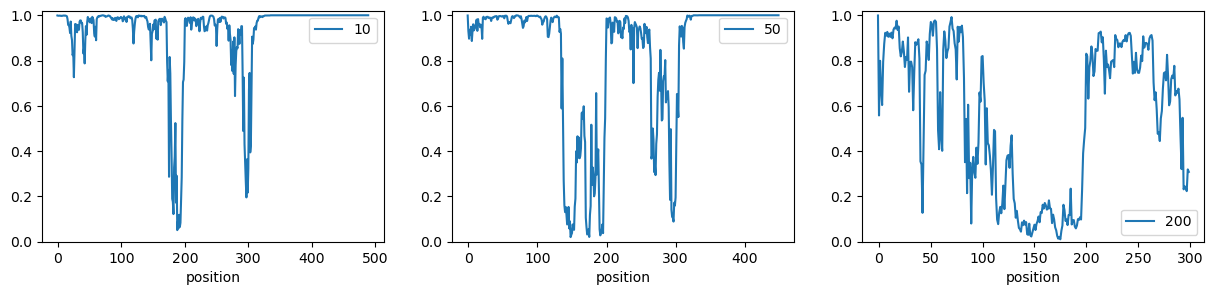


==== Sequence patch results: ======================================================================
MKTVLGFENIVKNRIKEIDPSADVLVAPKGFKGLVLAGSNAFDKDKFVKVLNKELIEAEKIIPIDLIVRADPNEICKGISGFVNEKISSDETFAVRTTRRGRHKFTSIDVNIIVGDCVRKYTGASVNLRYPDKIVLVEIIGEEAYISILPGSFEYHKYAPEKKELYRFFNKLSIIQMPYLGPIESVIEIGKRIGREVQNFEVKELVIAPIGLVDAYSLARFIDSVMEGIESRYRVQVKSYHRKPRKTPVYIMDLYQLIRDRGDEVIIVFEPEGRYIVDVKDELEELVLKSRKRINLLFGAREGIPTGIFRYADLVIDIAPGMVLSTDYAVAAGLIALSTILYDKYRSMDHESINTSGR

Calculating PATCH=10 results...
Min prediction (= 0.8537092208862305) for seq version was at interval (193, 203) (df row index = 194): MKTVLGFENIVKNRIKEIDPSADVLVAPKGFKGLVLAGSNAFDKDKFVKVLNKELIEAEKIIPIDLIVRADPNEICKGISGFVNEKISSDETFAVRTTRRGRHKFTSIDVNIIVGDCVRKYTGASVNLRYPDKIVLVEIIGEEAYISILPGSFEYHKYAPEKKELYRFFNKLSIIQMPYLGPIESVIEIGKRIXXXXXXXXXXELVIAPIGLVDAYSLARFIDSVMEGIESRYRVQVKSYHRKPRKTPVYIMDLYQLIRDRGDEVIIVFEPEGRYIVDVKDELEELVLKSRKRINLLFGAREGIPTGIFRYADLVIDIAPGMVLSTDYAVAAGLIALSTILYDKYRSMDHESINTSGR
Patched subseq: GREVQNFEVK

Calculating PATCH

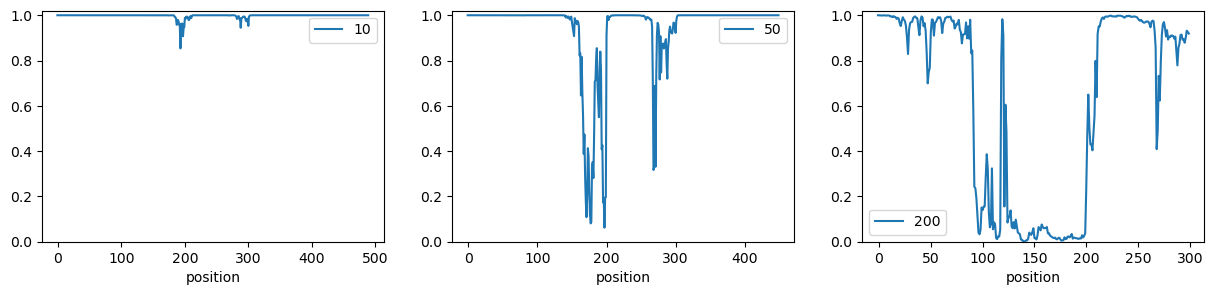


==== Sequence patch results: ======================================================================
MERVCASYIKDLNPKLEVVSAPKGFSGLVLVGGADDKYELARLIKERVPEADKVLIIEGVAKAEIPSIAEEVTKIIKDKISPDETFAVRTVRRGSHEFTSIDVNVAVGAKVKEVTGASVNLEFPDKVVAVEIIGGDAYISIIDGKELWRKKGPTKRPMYRLFRRFSIIHEPYLGPLDACRTMGIRIGREAQTFEVDELIIAPKGPVKALELKTFIEGVLEGIETRYQVQVKAYGRDVHKVRVYVQDMYQVVRDRSNEVLIVLEPEGKPVSQCIDELEELILRRRKRINLFIGAREGVPLGIYRFANLVLDIAPGITIATDYALSSALIAIATLIHDKFSEEW

Calculating PATCH=10 results...
Min prediction (= 0.9999074935913086) for seq version was at interval (264, 274) (df row index = 265): MERVCASYIKDLNPKLEVVSAPKGFSGLVLVGGADDKYELARLIKERVPEADKVLIIEGVAKAEIPSIAEEVTKIIKDKISPDETFAVRTVRRGSHEFTSIDVNVAVGAKVKEVTGASVNLEFPDKVVAVEIIGGDAYISIIDGKELWRKKGPTKRPMYRLFRRFSIIHEPYLGPLDACRTMGIRIGREAQTFEVDELIIAPKGPVKALELKTFIEGVLEGIETRYQVQVKAYGRDVHKVRVYVQDMYQVVRDRSNEVLIVLEPXXXXXXXXXXELEELILRRRKRINLFIGAREGVPLGIYRFANLVLDIAPGITIATDYALSSALIAIATLIHDKFSEEW
Patched subseq: EGKPVSQCID

Calculating PATCH=50 results...
Min prediction (=

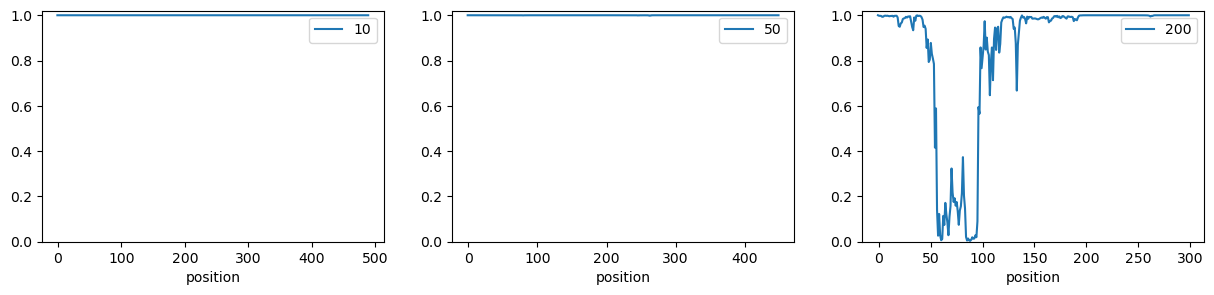


==== Sequence patch results: ======================================================================
MKTPLGLERIVASRAAELIGGHVVARPRGFMGLVVIDGLEDPDEAARRIEEALPEAEYVLRVLATARADLDEIASSAAHVARDLIRPDETFAVRTTRRGKHDFTSIDANVKVGSAVQEATGADVNLTEPDKIVWVEFIGPEVGIAITPGQVVWKKHRPGKPEVLRLLKRISFAQMPYLGEGGRPMGVRIGRAAQAFELSELVITPHEPVDVGQLNAFLSGLLEGRESRFKIQKKTYARKVDKVPFRLQDLYQFVRDRAGEPMIVTDPTGKTVSEAAEDIEEAFRQGGRVNILAGAREGVPKGVFRFATLIIDLCPGLTFATEHTIPATVGALITCLEERGLIRQ

Calculating PATCH=10 results...
Min prediction (= 0.5675257444381714) for seq version was at interval (189, 199) (df row index = 190): MKTPLGLERIVASRAAELIGGHVVARPRGFMGLVVIDGLEDPDEAARRIEEALPEAEYVLRVLATARADLDEIASSAAHVARDLIRPDETFAVRTTRRGKHDFTSIDANVKVGSAVQEATGADVNLTEPDKIVWVEFIGPEVGIAITPGQVVWKKHRPGKPEVLRLLKRISFAQMPYLGEGGRPMGVRIXXXXXXXXXXELVITPHEPVDVGQLNAFLSGLLEGRESRFKIQKKTYARKVDKVPFRLQDLYQFVRDRAGEPMIVTDPTGKTVSEAAEDIEEAFRQGGRVNILAGAREGVPKGVFRFATLIIDLCPGLTFATEHTIPATVGALITCLEERGLIRQ
Patched subseq: GRAAQAFELS

Calculating PATCH=50 results...
Min predictio

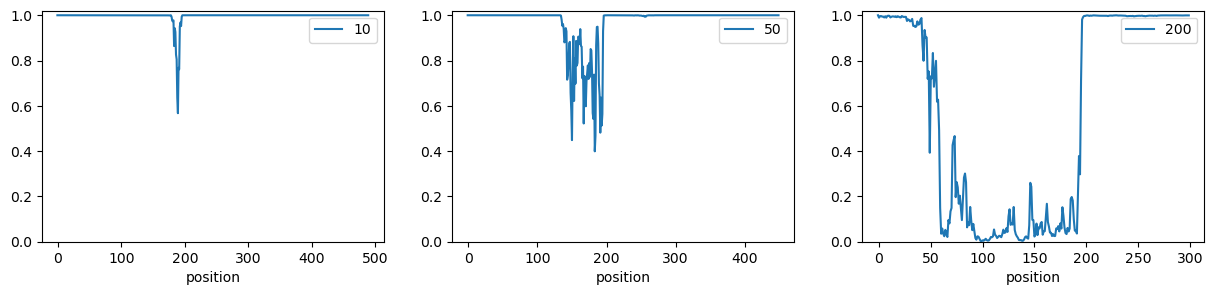


==== Sequence patch results: ======================================================================
MVDLIVKTVKGLERVAAARIKEALGNEVLVKARPLGFLGIVTVEGVRDKEEAKRIVESKVPEVERALVILGECKADLNEIAEVAKRLIRDRLSEAETFAVRTVRRGSHTFTSIDVNVRVGATVKEVTGADVNLSEPDKTIQVEIIGDKAYISLIEGTLELKKVRPGKPKIAPFLRRITVVQVPYLGDREASYKMGVRIGRGLQTFEIGGLYIAPFEPVPVEELEAFLQGVIEGRESRYRIQRRAYAREPFKVPIYLYDLYQYVRNKGSKEVIIATSTSGDPVWEALSKLEKALKGADKISILVGSRKGLPRGVFRFSDAVIDVAPSITLPTDYAAVAIIMAIVTVLEGRDFFDKY

Calculating PATCH=10 results...
Min prediction (= 0.9035285115242004) for seq version was at interval (200, 210) (df row index = 201): MVDLIVKTVKGLERVAAARIKEALGNEVLVKARPLGFLGIVTVEGVRDKEEAKRIVESKVPEVERALVILGECKADLNEIAEVAKRLIRDRLSEAETFAVRTVRRGSHTFTSIDVNVRVGATVKEVTGADVNLSEPDKTIQVEIIGDKAYISLIEGTLELKKVRPGKPKIAPFLRRITVVQVPYLGDREASYKMGVRIGRXXXXXXXXXXYIAPFEPVPVEELEAFLQGVIEGRESRYRIQRRAYAREPFKVPIYLYDLYQYVRNKGSKEVIIATSTSGDPVWEALSKLEKALKGADKISILVGSRKGLPRGVFRFSDAVIDVAPSITLPTDYAAVAIIMAIVTVLEGRDFFDKY
Patched subseq: GLQTFEIGGL

Calculating PATCH=50 re

KeyboardInterrupt: 

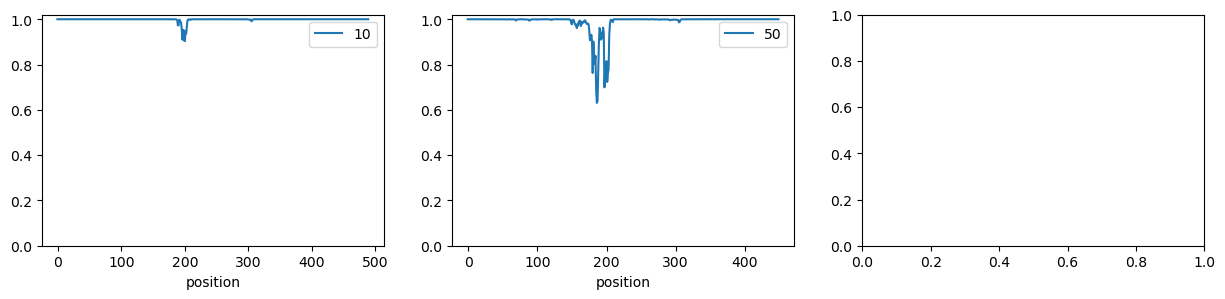

In [15]:
new_patch_sizes = [10, 50, 200]

all_scores = []
for i in range(1, 51):
    seq = data[i][0]
    
    # skip sequences that are too long
    if len(seq) > SEQ_DIM:
        print(f'Sequence (i={i}) is too long (len={len(seq)}), skipping.\n')
        continue

    seq_scores = calculate_one_seq_results(seq, new_patch_sizes)
    all_scores.append(seq_scores)

In [ ]:
import pickle

with open(BACKUP_FILE, 'wb') as file:
    pickle.dump(all_scores, file)

In [ ]:
# with open(BACKUP_FILE, 'rb') as file:
#     all_scores_backup = pickle.load(file)
#     print(len(all_scores_backup))